<a href="https://colab.research.google.com/github/erialc-cal/StatApp_2020/blob/main/Preparation%20reunion/Fonctions_de_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On automatise toutes les visualisations faites dans ce notebook afin de voir les différents indicateurs à des niveaux d'agrégation temporels différents. 


In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# Nettoyage

In [337]:
# Ancienne base 
# fqms=pd.read_csv(r'https://github.com/erialc-cal/StatApp_2020/raw/main/Data/FQMs/fqms_2016.csv')

# Chargement à partir du lien Git raw de la nouvelle base avec FQMs et Histos concaténés 
database = pd.read_csv('https://raw.githubusercontent.com/erialc-cal/StatApp_2020/main/Data/database_2016.csv', low_memory=False, decimal=',',encoding='utf-8')
# On filtre sur les vols ORLY 
df = database[database['Terrain'].isin(['ORLY'])]

df.head()

Unnamed: 0        Date  Faisceau      Pays             Ville Terrain  \
0     1840426  2016-08-31  Schengen  PORTUGAL             Porto    ORLY   
1     1840427  2016-08-31  National    FRANCE         Marseille    ORLY   
2     1840428  2016-08-31  Schengen   ESPAGNE          Minorque    ORLY   
3     1840429  2016-08-31  National    FRANCE  Toulouse Blagnac    ORLY   
4     1840430  2016-08-31  Schengen  PORTUGAL   Lisbonne Lisboa    ORLY   

  Terminal Aerog             Aerop Code Aerop  ...   ArrDep   NumVol TypAv  \
0     ORYS  ORYS             Porto       LPPR  ...   Départ  TVF3470   73H   
1     ORYW  ORYO         Marseille       LFML  ...  Arrivée  AFR6037   320   
2     ORYW  ORYO          Minorque       LEMH  ...   Départ  VLG8190   320   
3     ORYW  ORYO  Toulouse Blagnac       LFBO  ...   Départ  AFR6136   320   
4     ORYW  ORYO   Lisbonne Lisboa       LPPT  ...  Arrivée   TAP442   320   

  MVT  PAX  Date Equiv  MVT_FQM PAX_FQM Coeff_Rempl_FQM Sièges Corrections_ICI  
0   1  140  2015-08-26      1.0  103.95            0.55      188.5634623992838  
1   1  122  2015-09-02      1.0   133.5            0.75      177.6545501236368  
2   1   66  2015-09-02      1.0    99.0            0.55      177.6545501236368  
3   1  175  2015-09-02      1.0  108.58            0.61      177.6545501236368  
4   1  145  2015-09-02      1.0  150.66            0.93      177.6545501236368  

[5 rows x 22 columns]

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237620 entries, 0 to 237619
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unnamed: 0              237620 non-null  int64 
 1   Date                    237620 non-null  object
 2   Faisceau                237619 non-null  object
 3   Pays                    237620 non-null  object
 4   Ville                   237620 non-null  object
 5   Terrain                 237620 non-null  object
 6   Terminal                237620 non-null  object
 7   Aerog                   237620 non-null  object
 8   Aerop                   237620 non-null  object
 9   Code Aerop              237620 non-null  object
 10  Cie                     237620 non-null  object
 11  Code Cie                237620 non-null  object
 12  ArrDep                  237620 non-null  object
 13  NumVol                  237620 non-null  object
 14  TypAv                   237620 non-n

In [353]:
df = df.astype({'Date':'datetime64[ns]', 'Date Equiv':'datetime64[ns]', 'MVT_FQM':'float64', 'PAX_FQM':'float64', 'Coeff_Rempl_FQM':'float64','Sièges Corrections_ICI':'float64'})

In [354]:
df['Taux de remplissage réel']=df['PAX'].div(df['Sièges Corrections_ICI'])

In [374]:
df['A/D']= df['ArrDep']

In [375]:
df['A/D'] = df['A/D'].str.replace('Arrivée', 'A')
df['A/D'] = df['A/D'].str.replace('Départ','D')

## Formatage des dates 
Les informations récupérées sont au niveau jour. On va créer les niveaux : jour, année, mois et semaine pour nos observations. 

In [377]:
from datetime import datetime as dt
from tqdm import tqdm


df['Annee']= df['Date'].dt.strftime('%Y')
df['Mois']= df['Date'].dt.strftime('%m')
df['Semaine']= df['Date'].dt.strftime('%U')
df['Jour']=df['Date']


In [15]:
pd.unique(df['Annee']),pd.unique(df['Mois']), pd.unique(df['Semaine'])

(array(['2016'], dtype=object),
 array(['08', '07', '05', '04', '06', '03', '01', '02', '10', '09', '11',
        '12'], dtype=object),
 array(['35', '31', '22', '17', '26', '13', '04', '05', '03', '02', '01',
        '00', '06', '07', '08', '09', '10', '11', '12', '14', '15', '16',
        '18', '19', '20', '21', '23', '24', '25', '30', '27', '28', '29',
        '32', '33', '34', '44', '39', '36', '37', '38', '40', '41', '42',
        '43', '45', '46', '47', '48', '52', '49', '50', '51'], dtype=object))

Descriptif de la base concaténée : 

```
Variables pour agréger temporellement : 
- Date (date complète)
- Semaine (correspond au numéro de la semaine)
- Annee (correspond à l'année entre 2016 et 2017)
- Mois (correspond au numéro du mois entre 1 et 12)

Variables générales : 
- Faisceau
- Pays
- Ville
- Terrain
- Aerop/Code Aerop
- Aérog

Variables issues des FQMs :
- Sièges Corrections_ICI
- PAX
- MVT_FQM
- PAX_FQM
- Coeff_Rempl_FQM
- Date Equiv

Variables issues des histos :
- MVT
- PAX
- Cie/Code Cie
- ArrDep
- TypAv

```

In [18]:
pd.unique(df.Faisceau)

array(['Schengen', 'National', 'International', 'Autre UE', 'Dom Tom',
       nan], dtype=object)

# Fonctions de visualisation

## Affichage des variables quantitatives

On crée des fonctions de visualisation des variables estimées/réelles par faisceaux, par type de mouvement et à niveau d'agrégation choisi (jour, semaine, mois, année), et à type d'agrégation (somme, max, min, moyenne, ...).

In [398]:
def compare_reel_estime(agregation_temps,variable_fqms, variable_histo, func_agreg_fqms,func_agreg_histo):
  # agregation_temps prend la valeur de l'incrément de temps que l'on souhaite : date au jour, à la semaine, à l'année
  # variable_fqms prend la variable d'intérêt das fqms, variable histo celle dans histo
  # func_agreg_fqms est l'agrégation voulue sur les fqms (par ex le max, la somme, la moyenne etc.) de meme pour func_agreg_histo
                  
    sns.set(style='darkgrid')
    
    colors = ['red','blue'] 
    faisceaux =['Schengen', 'International', 'Autre UE', 'National', 'Dom Tom'] #Codage des faisceaux
    fig, axes = plt.subplots(nrows=6,ncols=2, figsize=(45,40))

  # sélection sur le type de mouvement
    df_a = df[df['A/D']== 'A']
    df_d = df[df['A/D']== 'D']

    for i in range(len(faisceaux)):
        # sur les arrivées
        df_a[df_a['Faisceau']==faisceaux[i]].groupby(agregation_temps).agg({variable_histo:func_agreg_histo}).plot(ax = axes[i,0],legend=True, subplots=True, color=colors[0])
        df_a[df_a['Faisceau']==faisceaux[i]].groupby(agregation_temps).agg({variable_fqms:func_agreg_fqms}).plot(ax = axes[i,0],legend=True, subplots=True, color=colors[1])
        # sur les départs 
        df_d[df_d['Faisceau']==faisceaux[i]].groupby(agregation_temps).agg({variable_histo:func_agreg_histo}).plot(ax = axes[i,1],legend=True, subplots=True, color=colors[0])
        df_d[df_d['Faisceau']==faisceaux[i]].groupby(agregation_temps).agg({variable_fqms:func_agreg_fqms}).plot(ax = axes[i,1],legend=True, subplots=True, color=colors[1])  

        axes[i, 0].legend()
        axes[i, 0].set_title('Faisceau de {}'.format(faisceaux[i]))

    df_a.groupby(agregation_temps).agg({variable_histo:func_agreg_histo}).plot(ax = axes[5,0],legend=True, subplots=True, color=colors[0])
    df_a.groupby(agregation_temps).agg({variable_fqms:func_agreg_fqms}).plot(ax = axes[5,0],legend=True, subplots=True, color=colors[1])
    df_d.groupby(agregation_temps).agg({variable_histo:func_agreg_histo}).plot(ax = axes[5,1],legend=True, subplots=True, color=colors[0], linestyle='--')
    df_d.groupby(agregation_temps).agg({variable_fqms:func_agreg_fqms}).plot(ax = axes[5,1],legend=True, subplots=True, color=colors[1], linestyle='--')
    axes[5,0].legend()
    axes[5,0].set_title('Tous faisceaux compris')
    fig.suptitle('Observation au  {}'.format(agregation_temps)+ '\n des {}'.format(variable_fqms) +'\n et {}'.format(variable_histo)+ '\n au niveau {}'.format(func_agreg_fqms))


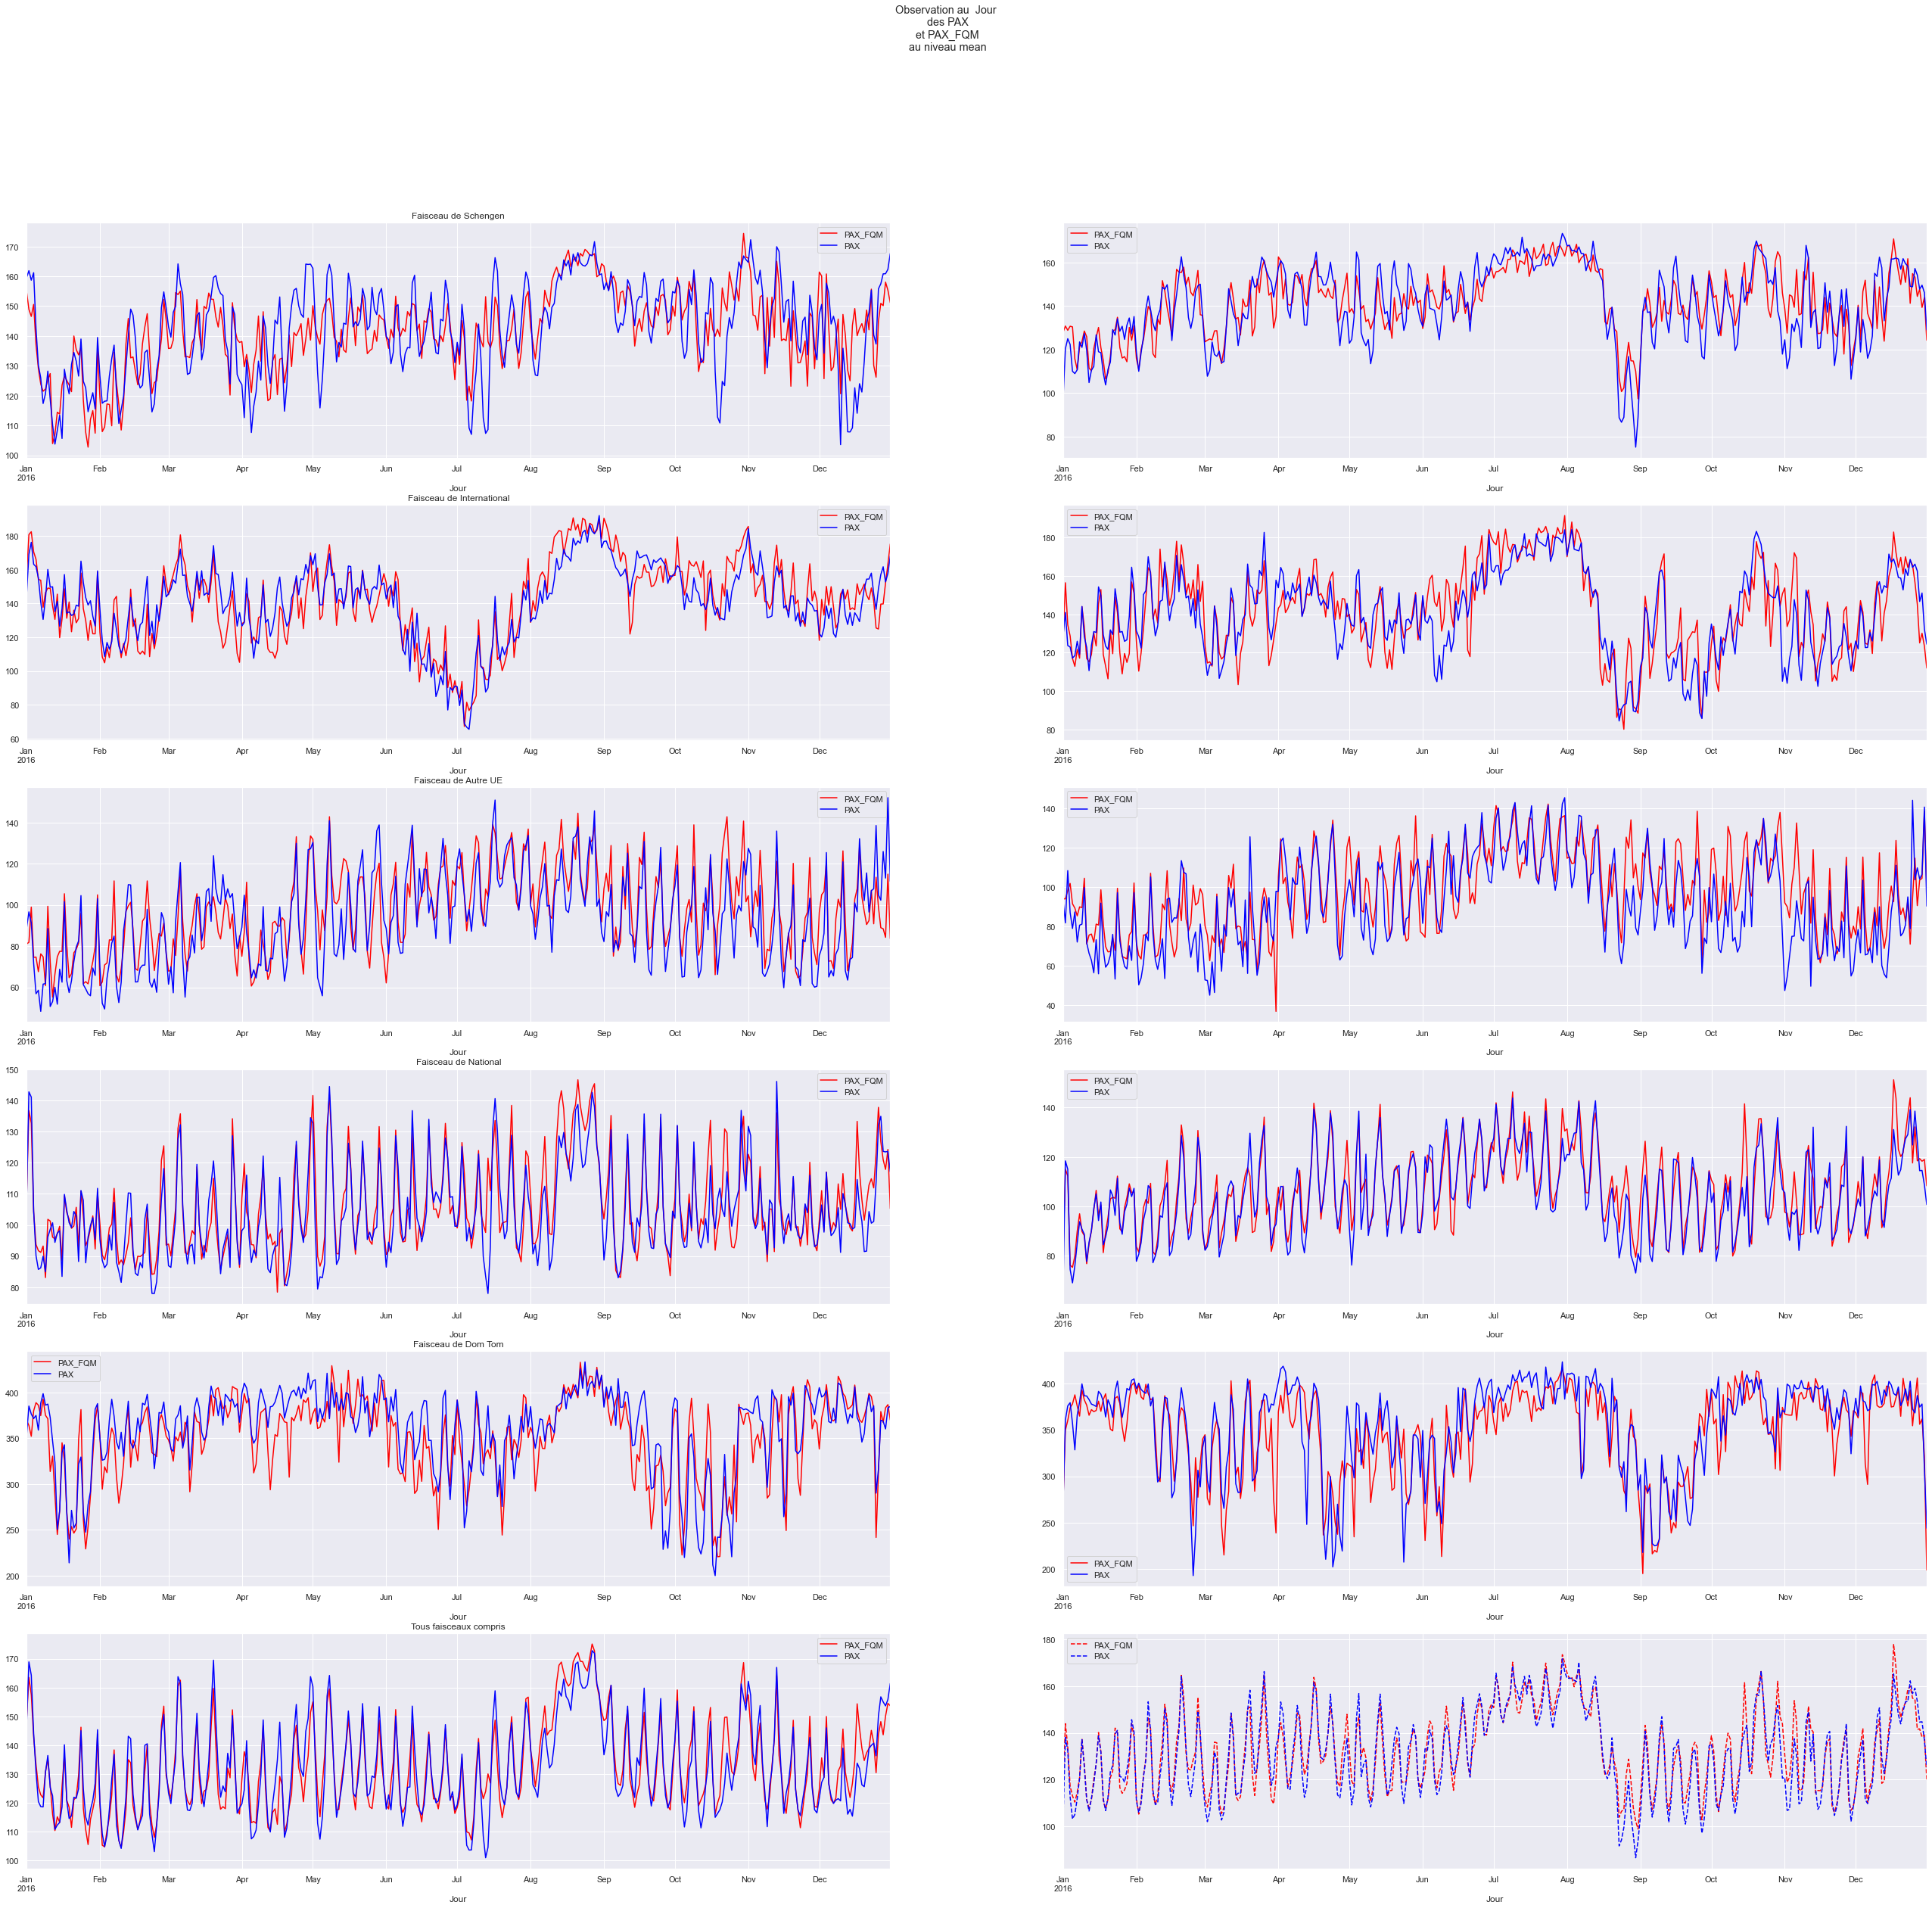

In [399]:
compare_reel_estime('Jour','PAX', 'PAX_FQM', 'mean', 'mean')

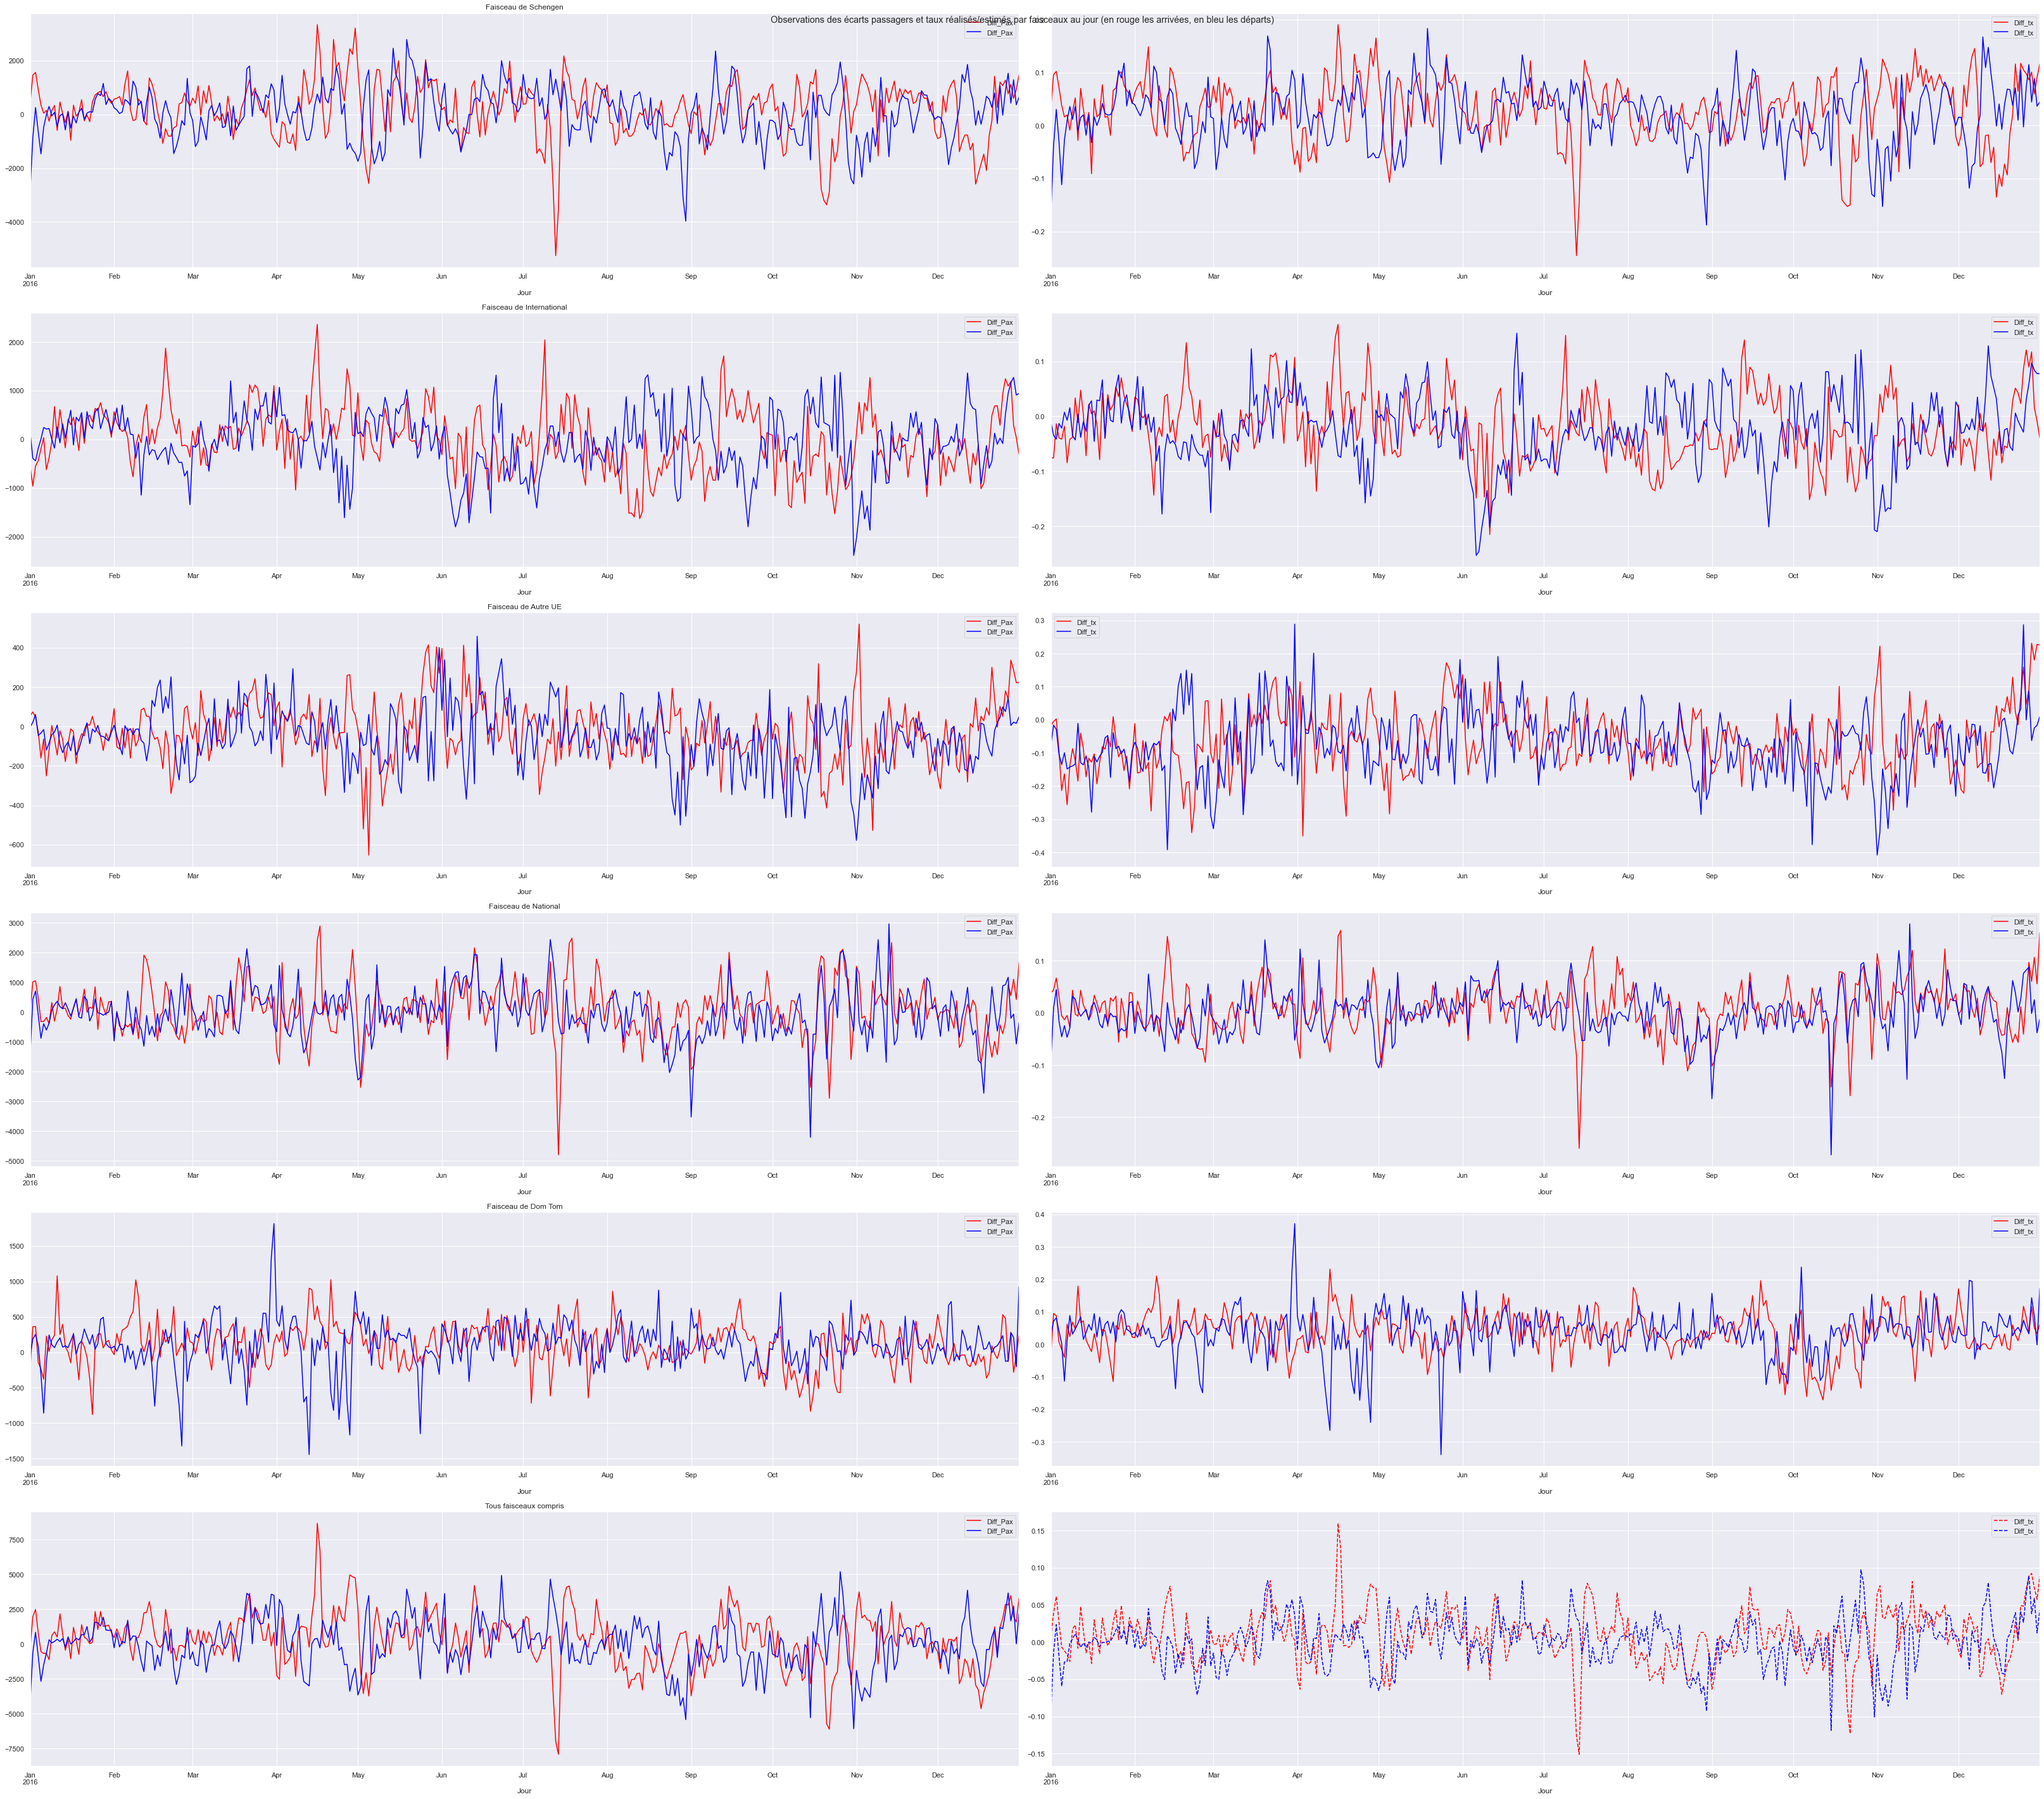

In [388]:

colors = ['red','blue'] 
faisceaux =['Schengen', 'International', 'Autre UE', 'National', 'Dom Tom'] #Codage des faisceaux
fig, axes = plt.subplots(nrows=6,ncols=2, figsize=(45,40))

df['Diff_Pax']= df['PAX']-df['PAX_FQM']
df['Diff_tx']=df['Taux de remplissage réel'] - df['Coeff_Rempl_FQM']
# sélection sur le type de mouvement
df_a = df[df['A/D']== 'A']
df_d = df[df['A/D']== 'D']

for i in range(len(faisceaux)):
    # sur les Pax
    df_a[df_a['Faisceau']==faisceaux[i]].groupby('Jour').agg({'Diff_Pax':'sum'}).plot(ax = axes[i,0],legend=True, subplots=True, color=colors[0])
    df_d[df_d['Faisceau']==faisceaux[i]].groupby('Jour').agg({'Diff_Pax':'sum'}).plot(ax = axes[i,0],legend=True, subplots=True, color=colors[1])
    # sur les taux 
    df_a[df_a['Faisceau']==faisceaux[i]].groupby('Jour').agg({'Diff_tx':'mean'}).plot(ax = axes[i,1],legend=True, subplots=True, color=colors[0])
    df_d[df_d['Faisceau']==faisceaux[i]].groupby('Jour').agg({'Diff_tx':'mean'}).plot(ax = axes[i,1],legend=True, subplots=True, color=colors[1])  
    
    axes[i, 0].legend()
    axes[i, 0].set_title('Faisceau de {}'.format(faisceaux[i]))

df_a.groupby('Jour').agg({'Diff_Pax':'sum'}).plot(ax = axes[5,0],legend=True, subplots=True, color=colors[0])
df_d.groupby('Jour').agg({'Diff_Pax':'sum'}).plot(ax = axes[5,0],legend=True, subplots=True, color=colors[1])
df_a.groupby('Jour').agg({'Diff_tx':'mean'}).plot(ax = axes[5,1],legend=True, subplots=True, color=colors[0], linestyle='--')
df_d.groupby('Jour').agg({'Diff_tx':'mean'}).plot(ax = axes[5,1],legend=True, subplots=True, color=colors[1], linestyle='--')
axes[5,0].legend()
axes[5,0].set_title('Tous faisceaux compris')
fig.suptitle('Observations des écarts passagers et taux réalisés/estimés par faisceaux au jour (en rouge les arrivées, en bleu les départs)')
plt.tight_layout()

In [387]:
df['Diff_Pax'].sum(), df['Diff_tx'].mean()

(112267.88464352985, 0.004205754857461945)

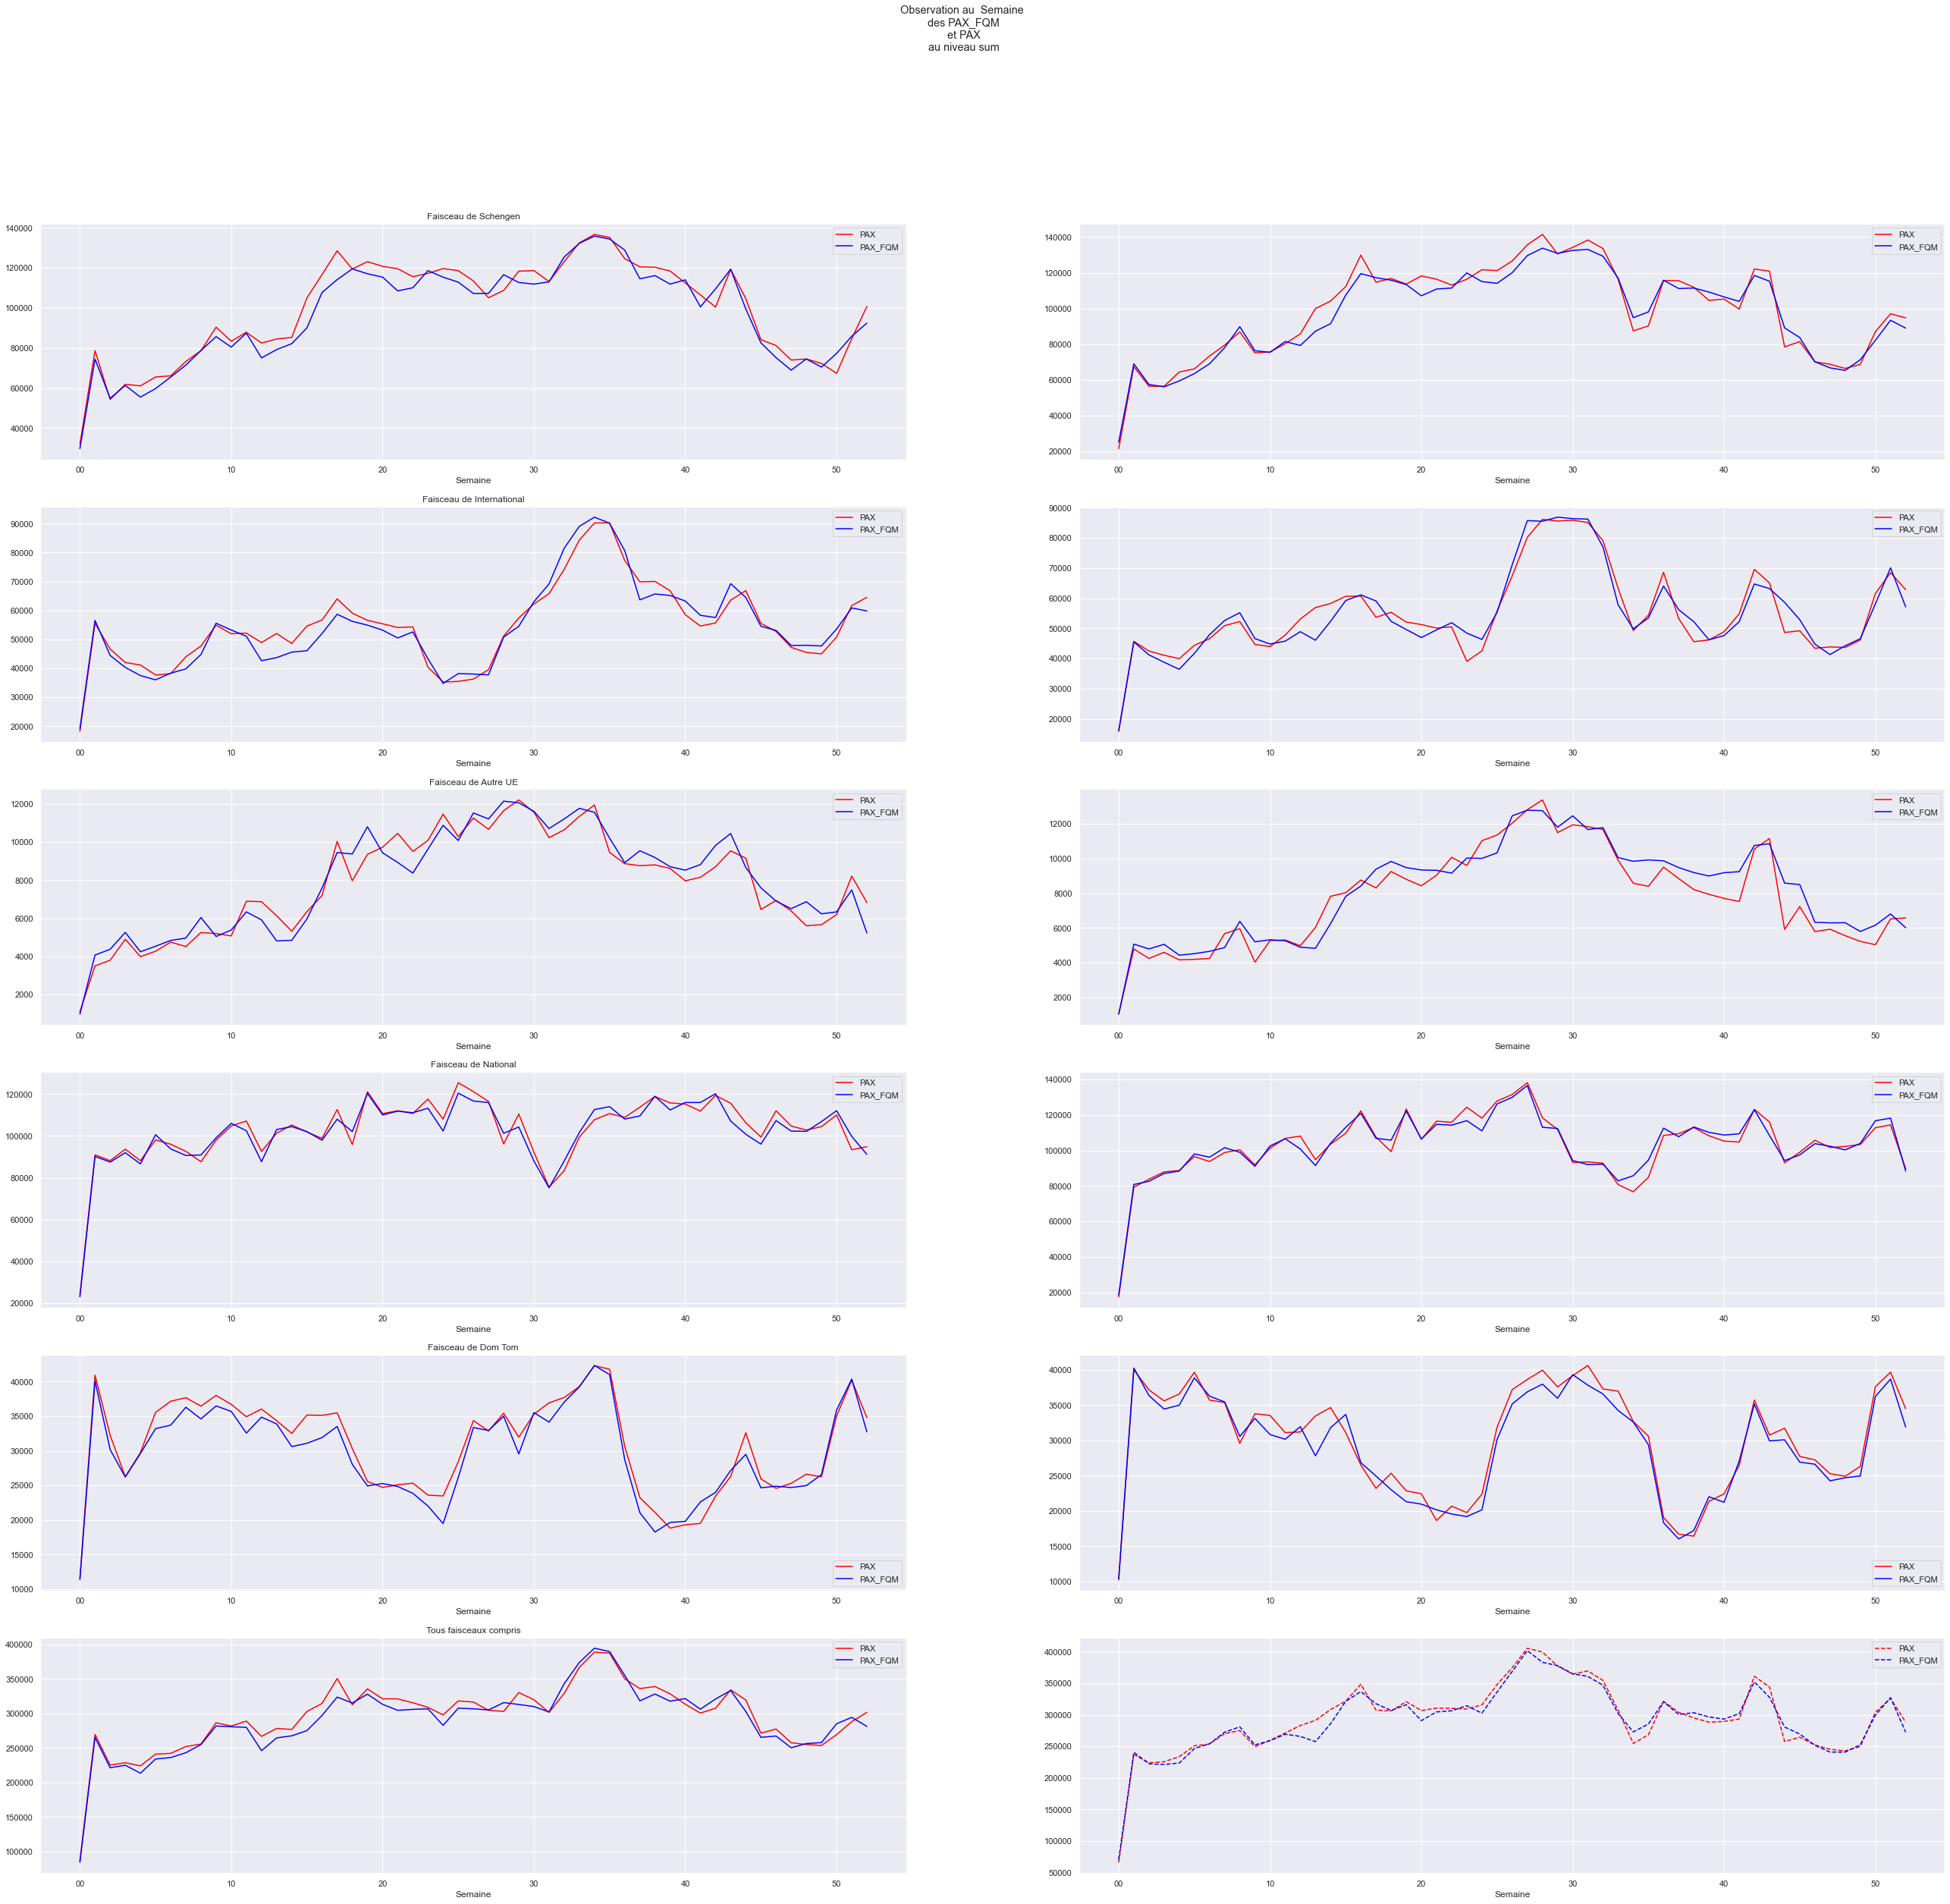

In [400]:
compare_reel_estime('Semaine','PAX_FQM', 'PAX', 'sum', 'sum')

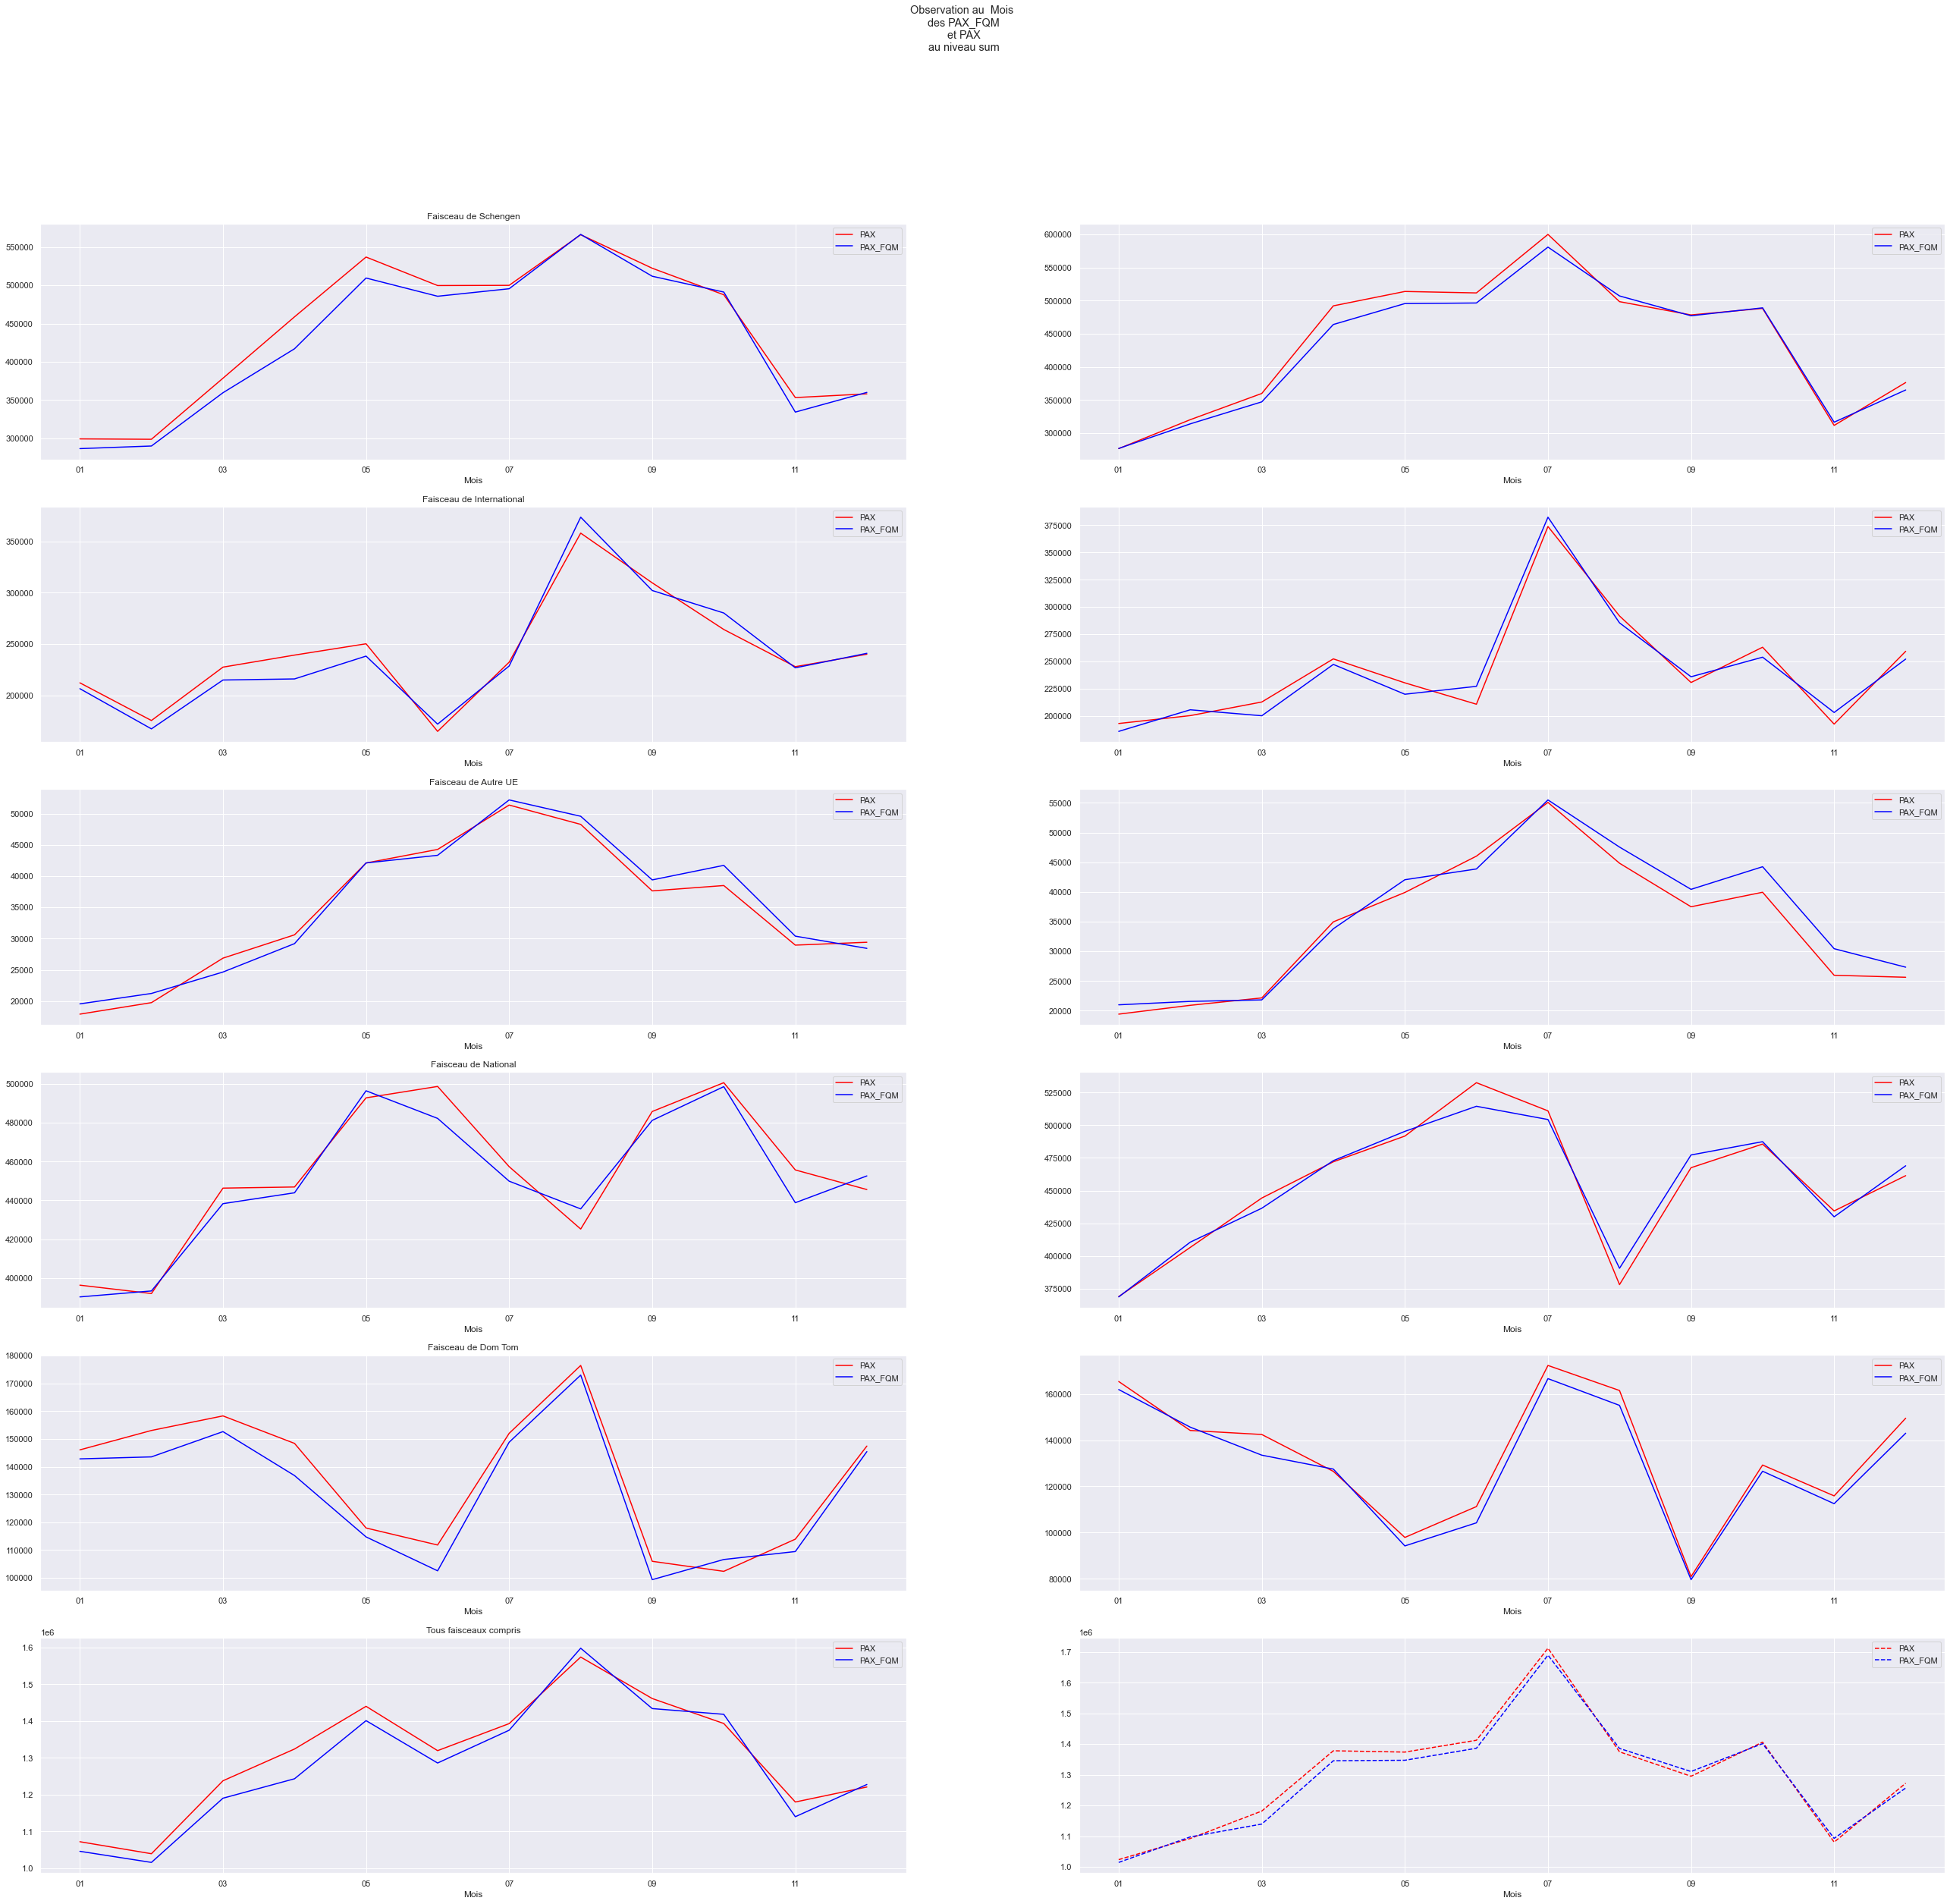

In [401]:
compare_reel_estime('Mois','PAX_FQM', 'PAX', 'sum', 'sum')

### Affichage d'une donnée par faisceaux et par type de mouvements 


In [42]:
def affichage_simple(agregation, variable_affichee, func):
                # agregation : observation par semaine, par jour, par année, par mois... ou sur prov/dst par ex.
                # variable affichee : LF%, Nombre de passagers estimés, etc. 
                # Fonction d'agrégation : 'mean' pour LF%, 'sum' pour Pax Estimés etc. 
                
  sns.set(style='darkgrid')
  faisceaux =['Schengen', 'International', 'Autre UE', 'National', 'Dom Tom']
  color=['blue', 'red', 'navy', 'gray', 'green']
  fig, ax = plt.subplots(2,1, sharex=False, figsize=(25,20))
  tm = ['Arrivée', 'Départ']

  df_a = df[df['A/D']=='A']
  df_d = df[df['A/D']=='D']
  for i in range(len(faisceaux)):
    #arrivées
    df_date_a = df_a[df_a['Faisceau']==faisceaux[i]].groupby(agregation).agg({variable_affichee :func})
    df_date_a['index']=df_date_a.index
    sns.regplot(ax=ax[0], x=df_date_a.index, y=df_date_a[variable_affichee], color=color[i], fit_reg=False, label=faisceaux[i])
    sns.lineplot(ax=ax[0], x='index',y=variable_affichee, data=df_date_a, color=color[i], label=tm[0])
    #départs
    df_date_d = df_d[df_d['Faisceau']==faisceaux[i]].groupby(agregation).agg({variable_affichee :func})
    df_date_d['index']=df_date_d.index
    sns.regplot(ax=ax[1], x=df_date_d.index, y=df_date_d[variable_affichee], color=color[i], fit_reg=False, label=faisceaux[i])
    sns.lineplot(ax=ax[1], x='index',y=variable_affichee, data=df_date_d, color=color[i],label=tm[1])
    
    ax[0].set(ylabel=variable_affichee+ '\n'+tm[0])
    ax[1].set(ylabel=variable_affichee+'\n'+tm[1])

  plt.title("Evolution du {}".format(variable_affichee)+" selon les {}".format(agregation)+" par faisceaux")





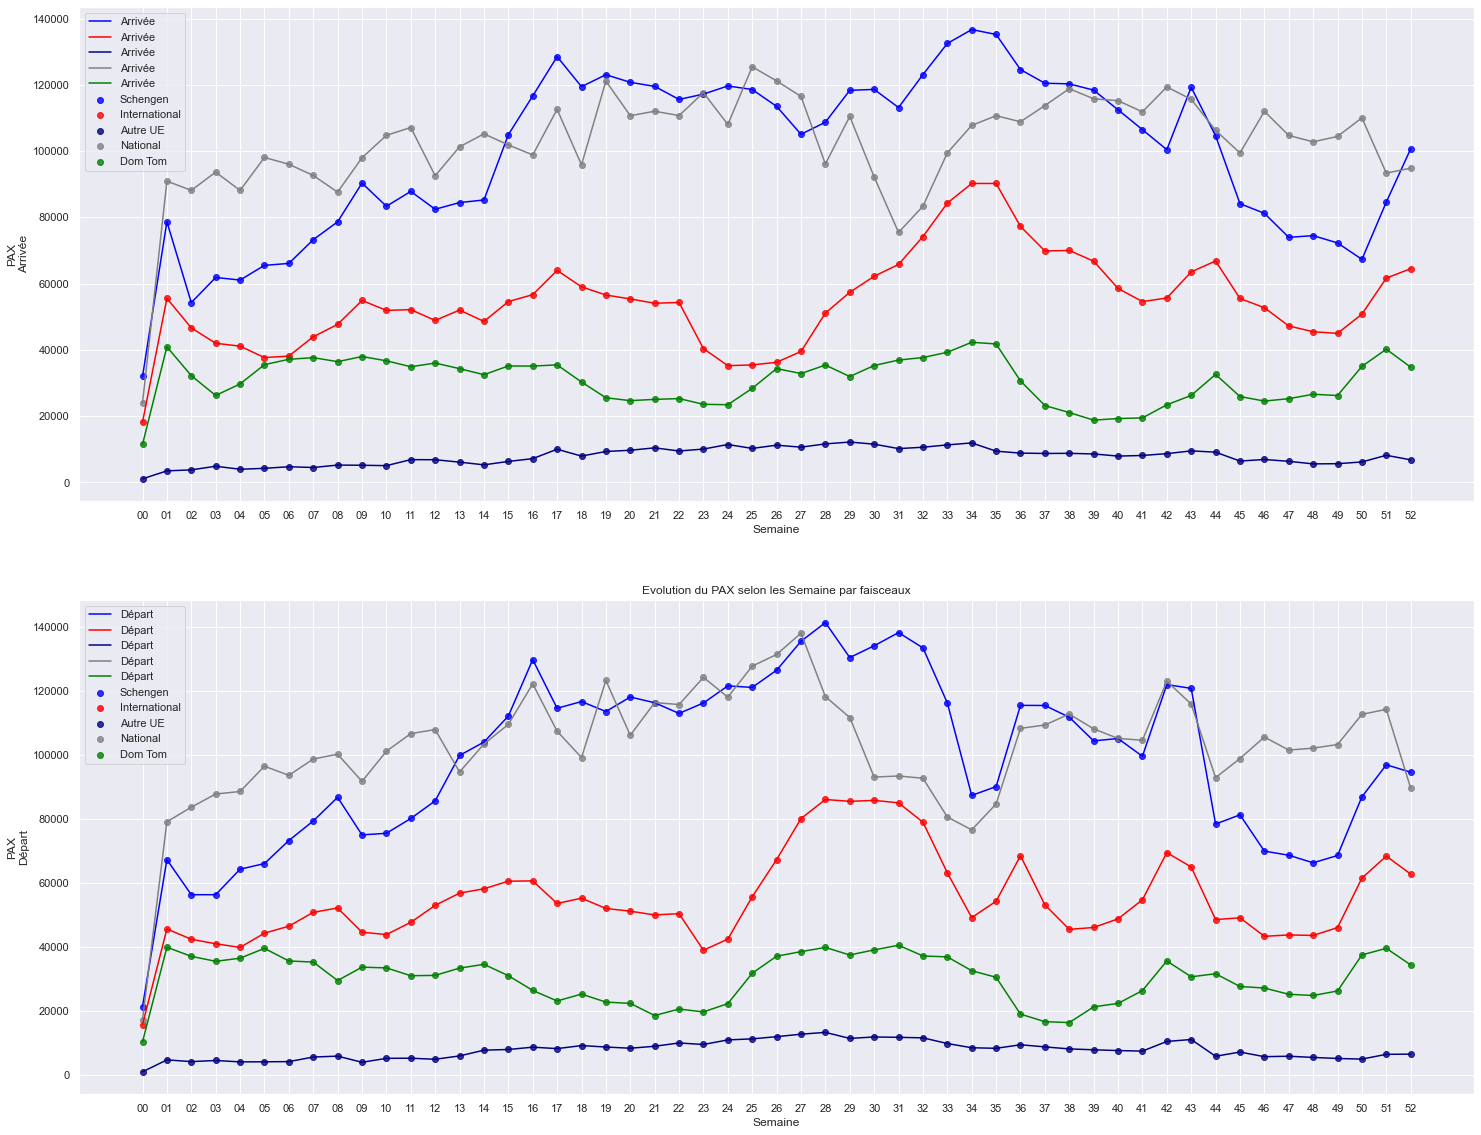

In [406]:
affichage_simple('Semaine', 'PAX', 'sum')

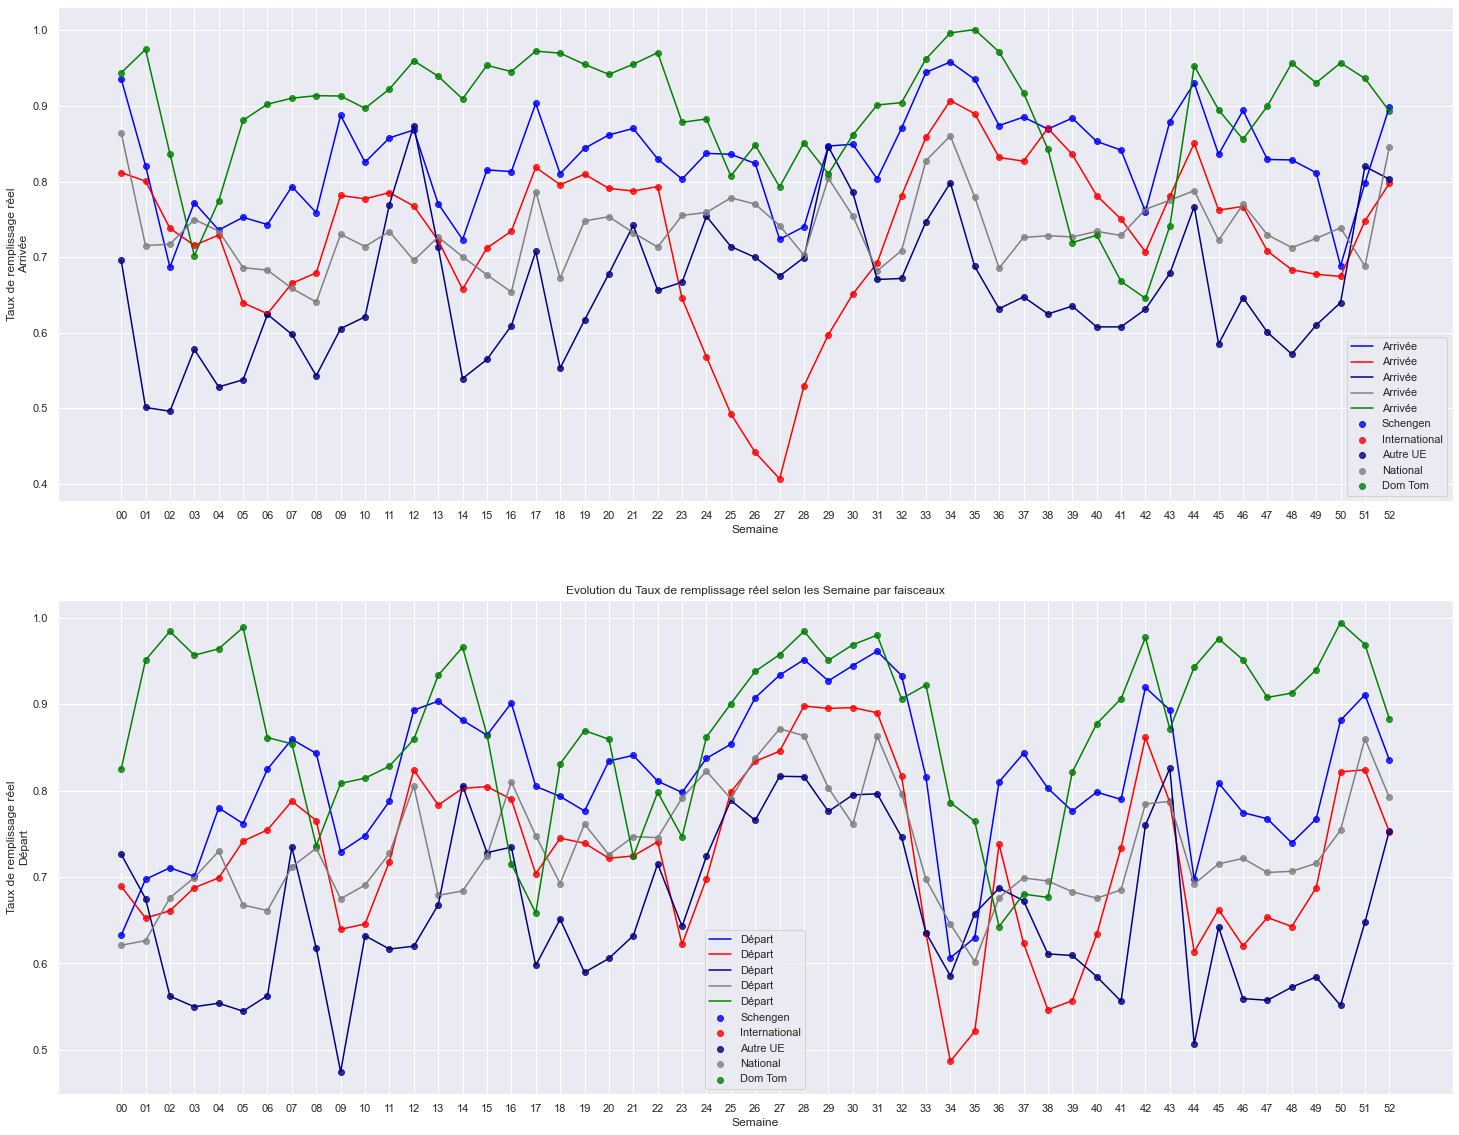

In [44]:
affichage_simple('Semaine', 'Taux de remplissage réel', 'mean')

## Affichage des variables catégorielles par faisceaux

### Comparaison données estimées/données réelles

In [195]:
def compare_categ(variable_cat, n_items,variable_histo, variable_fqms, func):
    faisceaux =['Schengen', 'International', 'Autre UE', 'National', 'Dom Tom']
    fig, ax = plt.subplots(6,1,figsize=(12,30))
    for i in range(len(faisceaux)):
        df_f = df[df.Faisceau == faisceaux[i]]
        df_f[df_f[variable_cat].isin(df_f[variable_cat].value_counts().sort_values().tail(n_items).index.tolist())].groupby(variable_cat).agg({variable_histo:func, variable_fqms:func})[[variable_histo, variable_fqms]].plot(ax=ax[i], kind='bar')
        ax[i].set_title(faisceaux[i])
    mask = df[variable_cat].isin(df[variable_cat].value_counts().sort_values(ascending=False).index.tolist()[:n_items])
    df[mask].groupby(variable_cat).agg({variable_histo:func, variable_fqms:func})[[variable_histo, variable_fqms]].plot(ax = ax[5],kind='bar')   
    plt.title('Fréquence de {}'.format(variable_histo) + '\n et \n {}'.format(variable_fqms)+ '\n par {}'.format(variable_cat))
    plt.tight_layout()

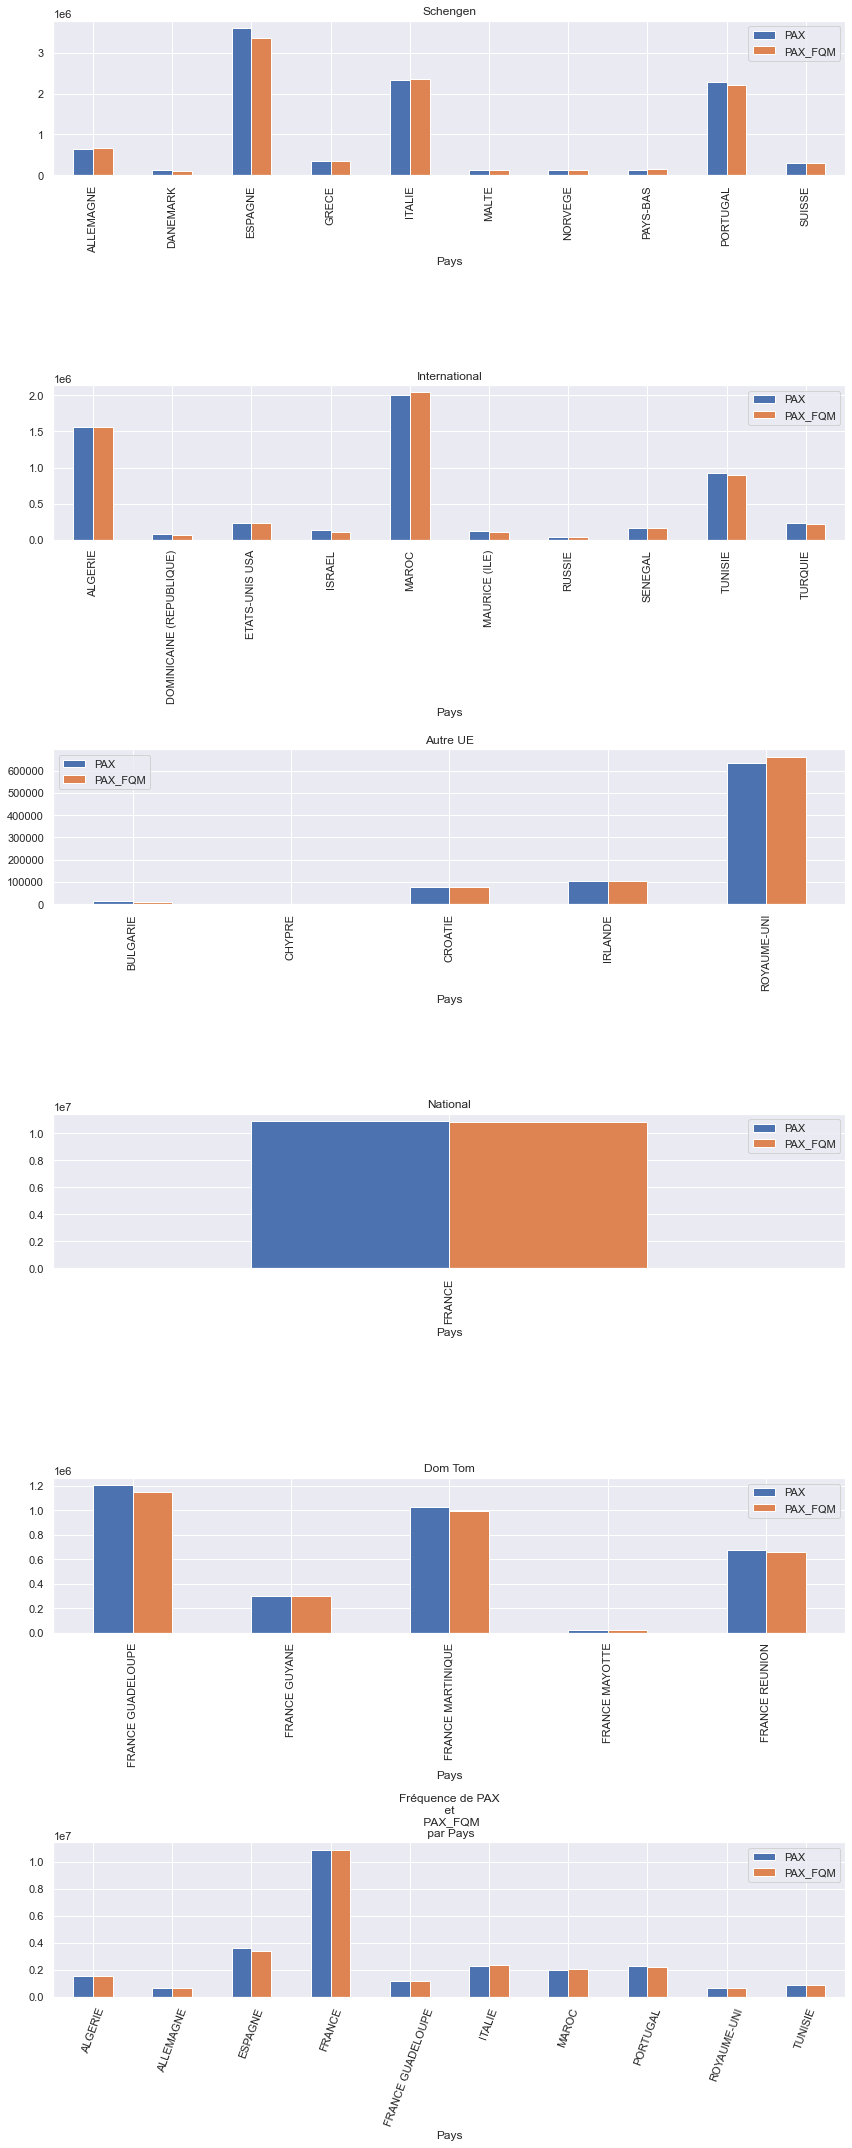

In [194]:
compare_categ('Pays', 10, 'PAX', 'PAX_FQM', 'sum')

In [196]:
#fig, ax = plt.subplots(figsize=(12,8))
#df[df['Pays'].isin(df['Pays'].value_counts().sort_values().tail(20).index.tolist())].groupby('Pays').agg({'PAX':'sum', 'PAX_FQM':'sum'})[['PAX', 'PAX_FQM']].plot(ax=ax, kind='bar')

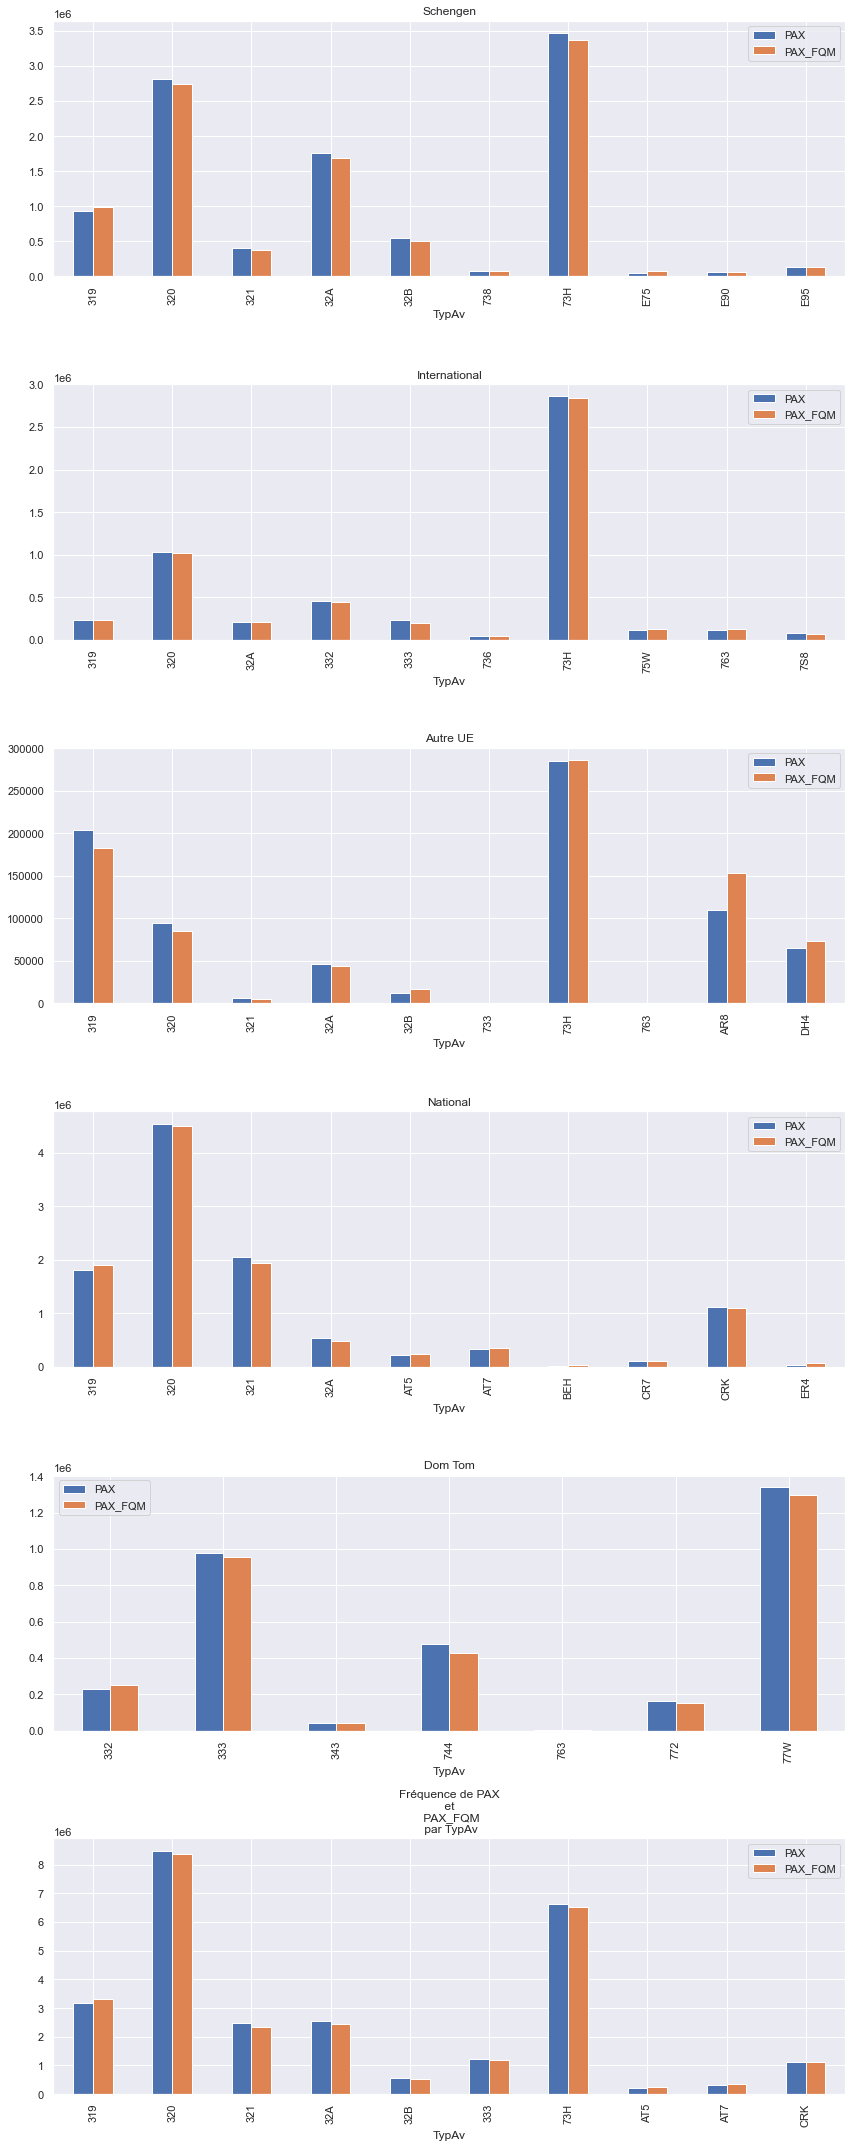

In [197]:
compare_categ('TypAv', 10, 'PAX', 'PAX_FQM', 'sum')

### Affichage simple par variable

In [45]:
def bar_chart_fsc(cat_variable, variable_of_interest, func_agreg, n_items):
      # cat_variable : variable catégorielle à observer
      # variable of interest : variable sur l'axe des y
      # fonction d'agrégation de la variable d'intérêt (max, mean, sum)
      # n_items : nombre maximal d'affichage des plus importantes variables catégorielles
  faisceaux =['Schengen', 'International', 'Autre UE', 'National', 'Dom Tom'] #Codage des faisceaux dans fqms
  fig, axes = plt.subplots(nrows=6,ncols=1, figsize=(45,40))

  for i in range(len(faisceaux)):
    df_f=df[df['Faisceau']==faisceaux[i]]
    top_list_cv = sorted(df_f[cat_variable].value_counts().nlargest(n_items).index.tolist())
    df_top = df_f[df_f[cat_variable].isin(top_list_cv)]
    data_cv = df_top.groupby(cat_variable).agg({variable_of_interest:func_agreg})
    data_cv[cat_variable]= data_cv.index
    sns.barplot(cat_variable, variable_of_interest, data=data_cv,ax=axes[i])
    axes[i].set_title("{}".format(variable_of_interest)+" par {}".format(cat_variable) +" pour le faisceau "+ faisceaux[i])
  
  top_list_cv = sorted(df[cat_variable].value_counts().nlargest(n_items).index.tolist())
  df_ag = df[df[cat_variable].isin(top_list_cv)]
  data_cv = df_ag.groupby(cat_variable).agg({variable_of_interest:func_agreg})
  data_cv[cat_variable]=data_cv.index
  sns.barplot(cat_variable, variable_of_interest, data=data_cv,ax=axes[5])
  axes[5].set_title("{}".format(variable_of_interest)+" par {}".format(cat_variable) +" sur l'ensemble des faisceaux")




Graphique des 5 provenances/destinations avec le plus de passagers estimés par faisceaux.

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

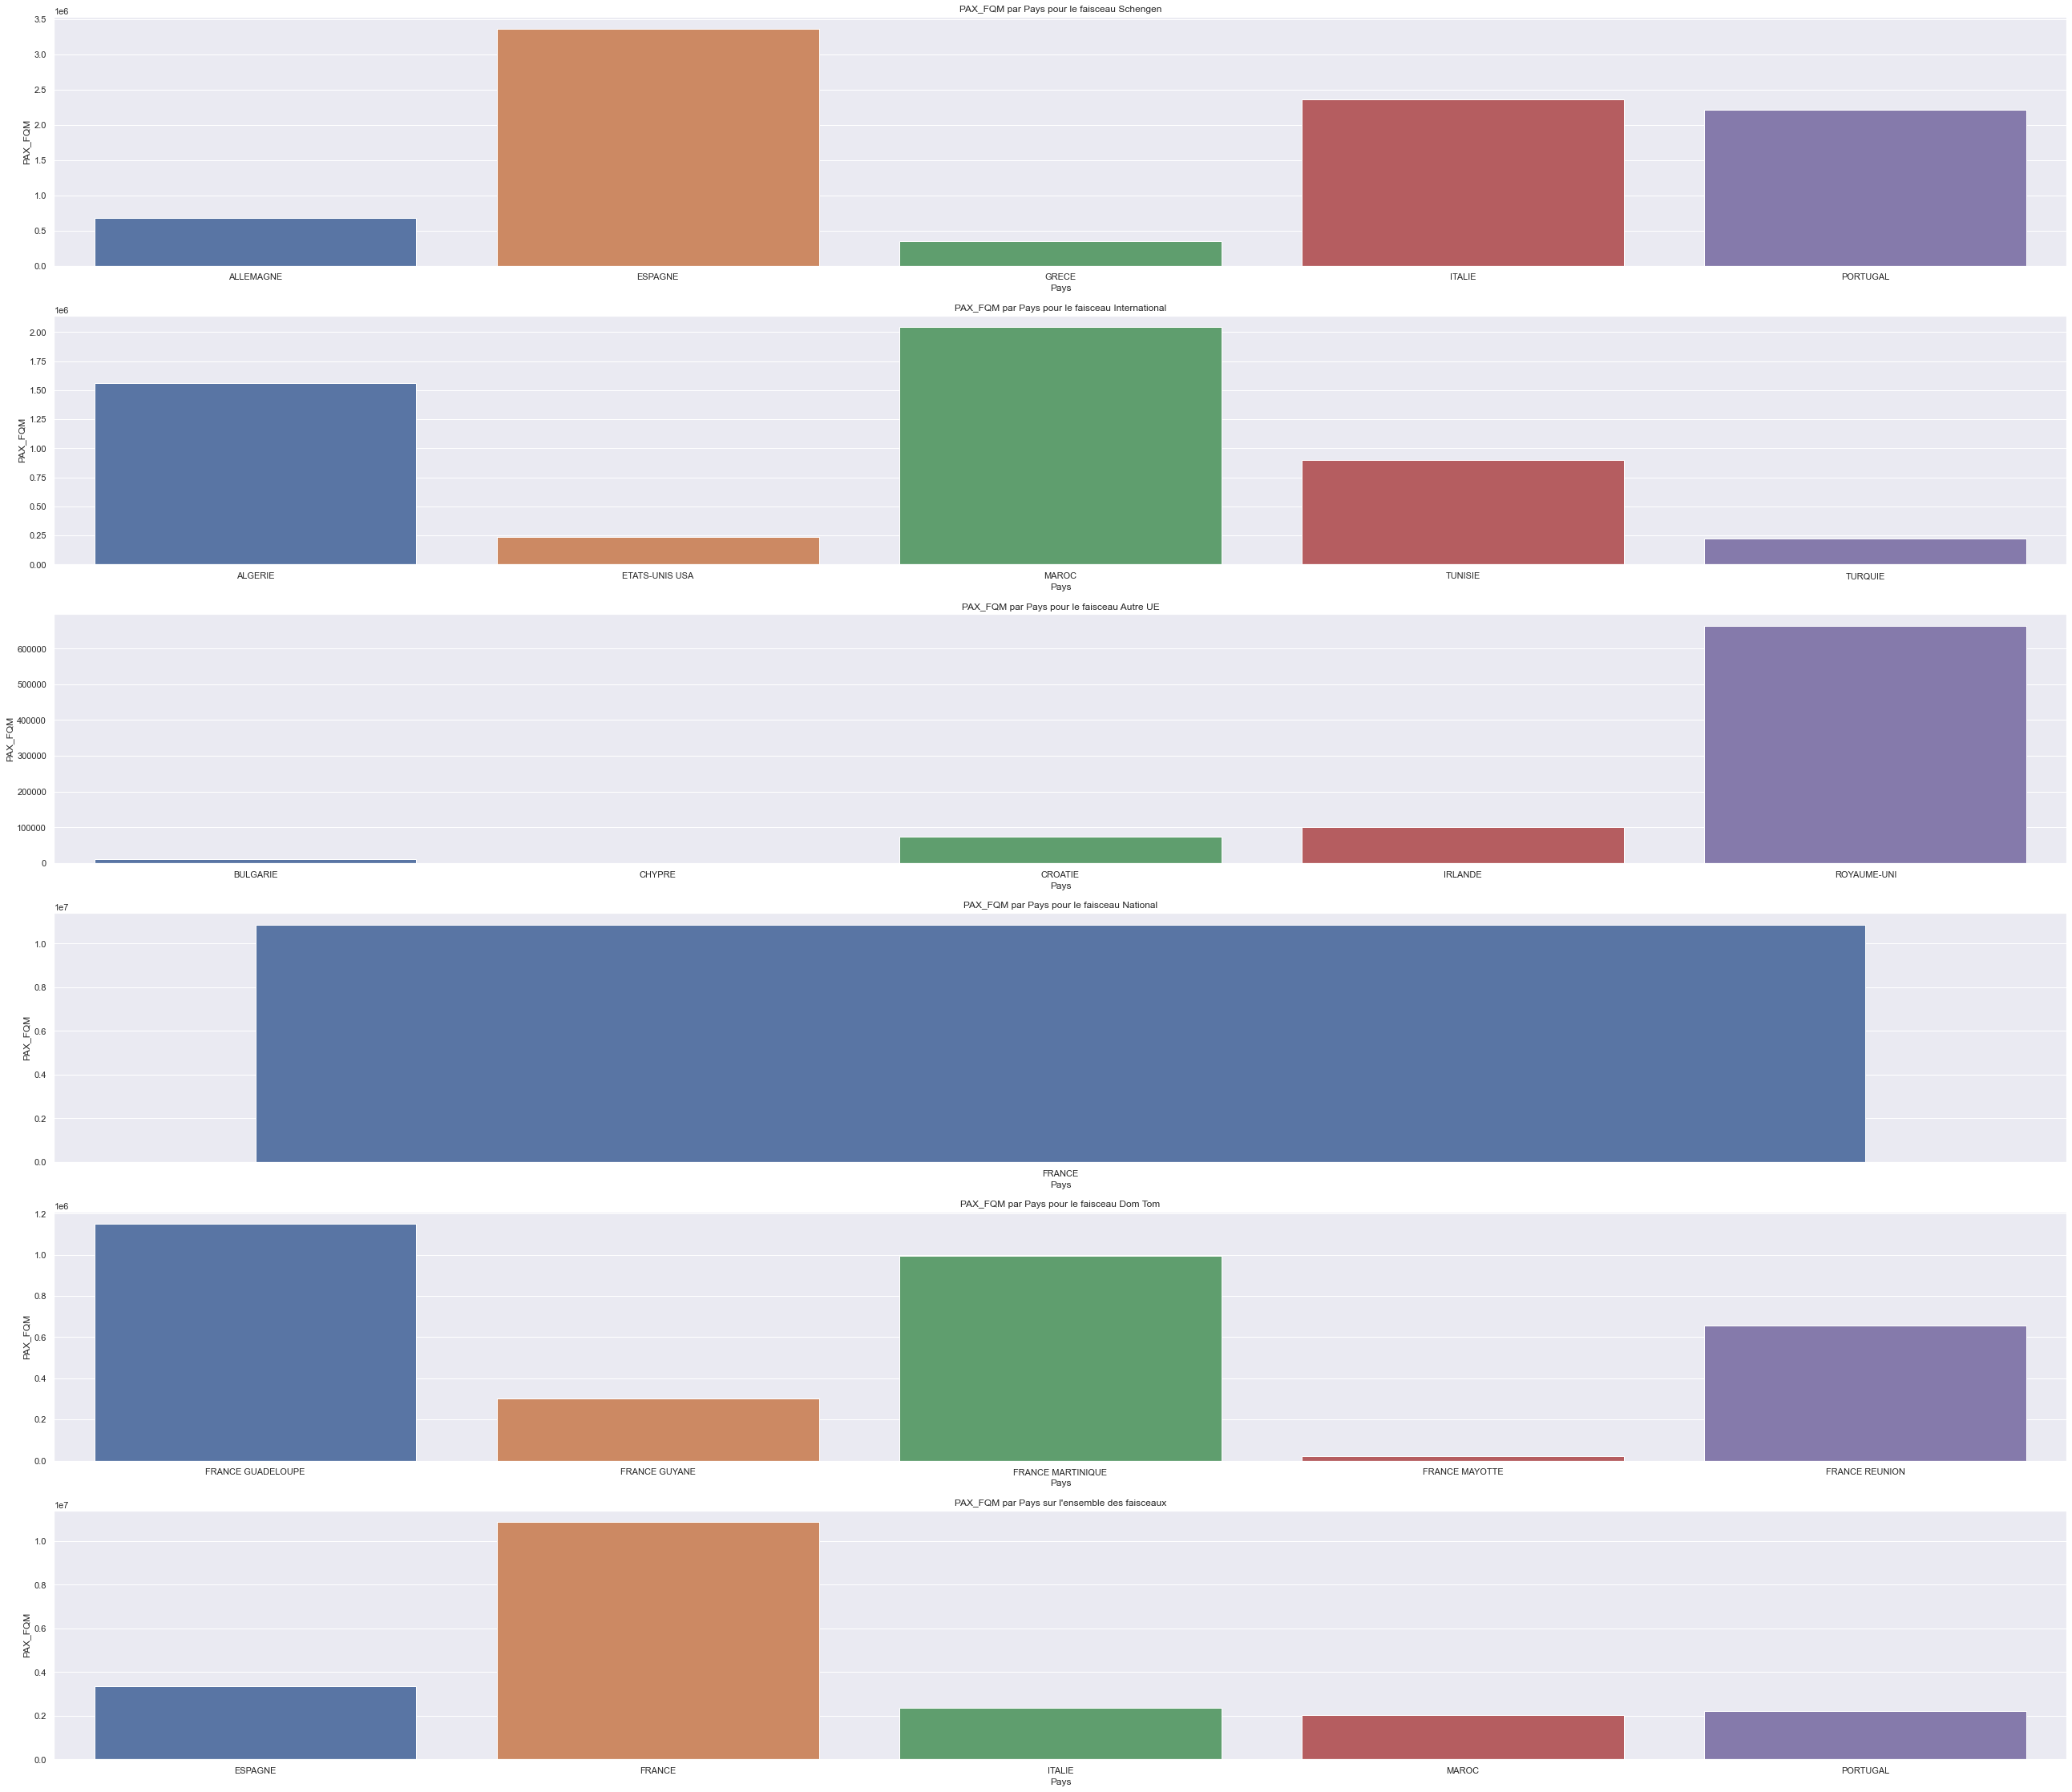

In [48]:
bar_chart_fsc('Pays', 'PAX_FQM', 'sum', 5)

Graphique des 5 provenances et destinations les plus fréquentes en nombre de vols par faisceaux

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

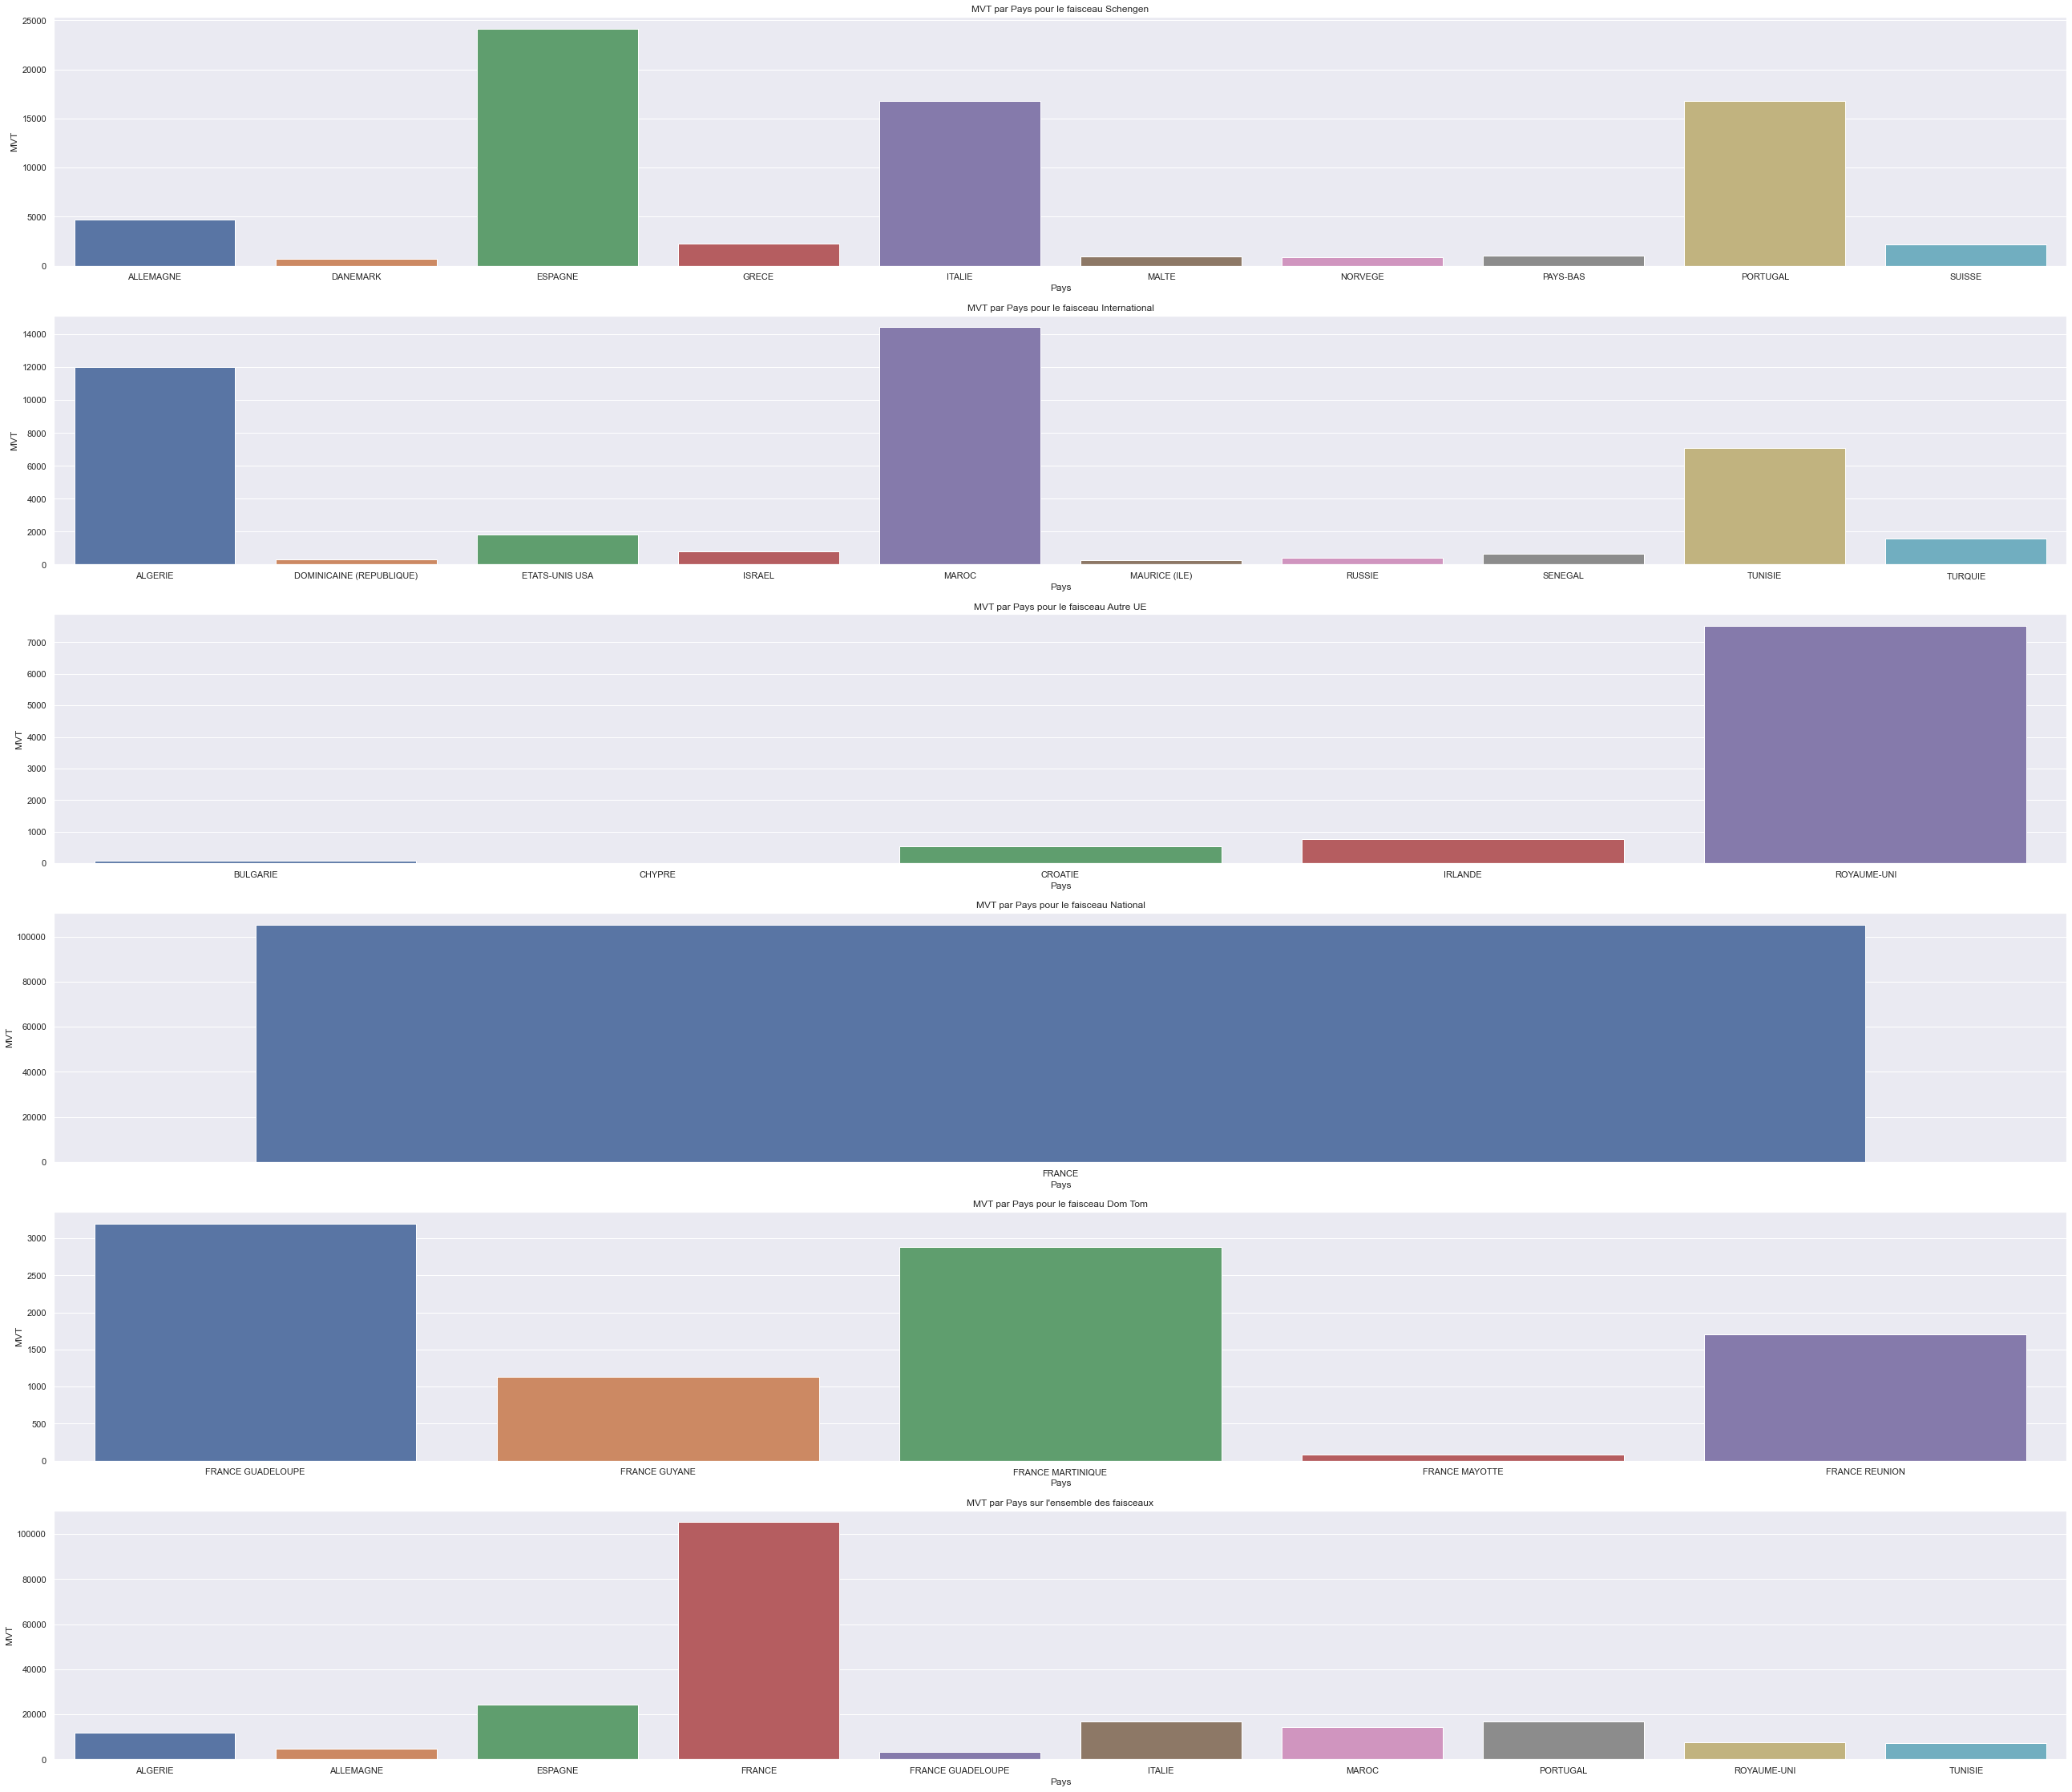

In [49]:
bar_chart_fsc('Pays', 'MVT', 'sum', 10)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

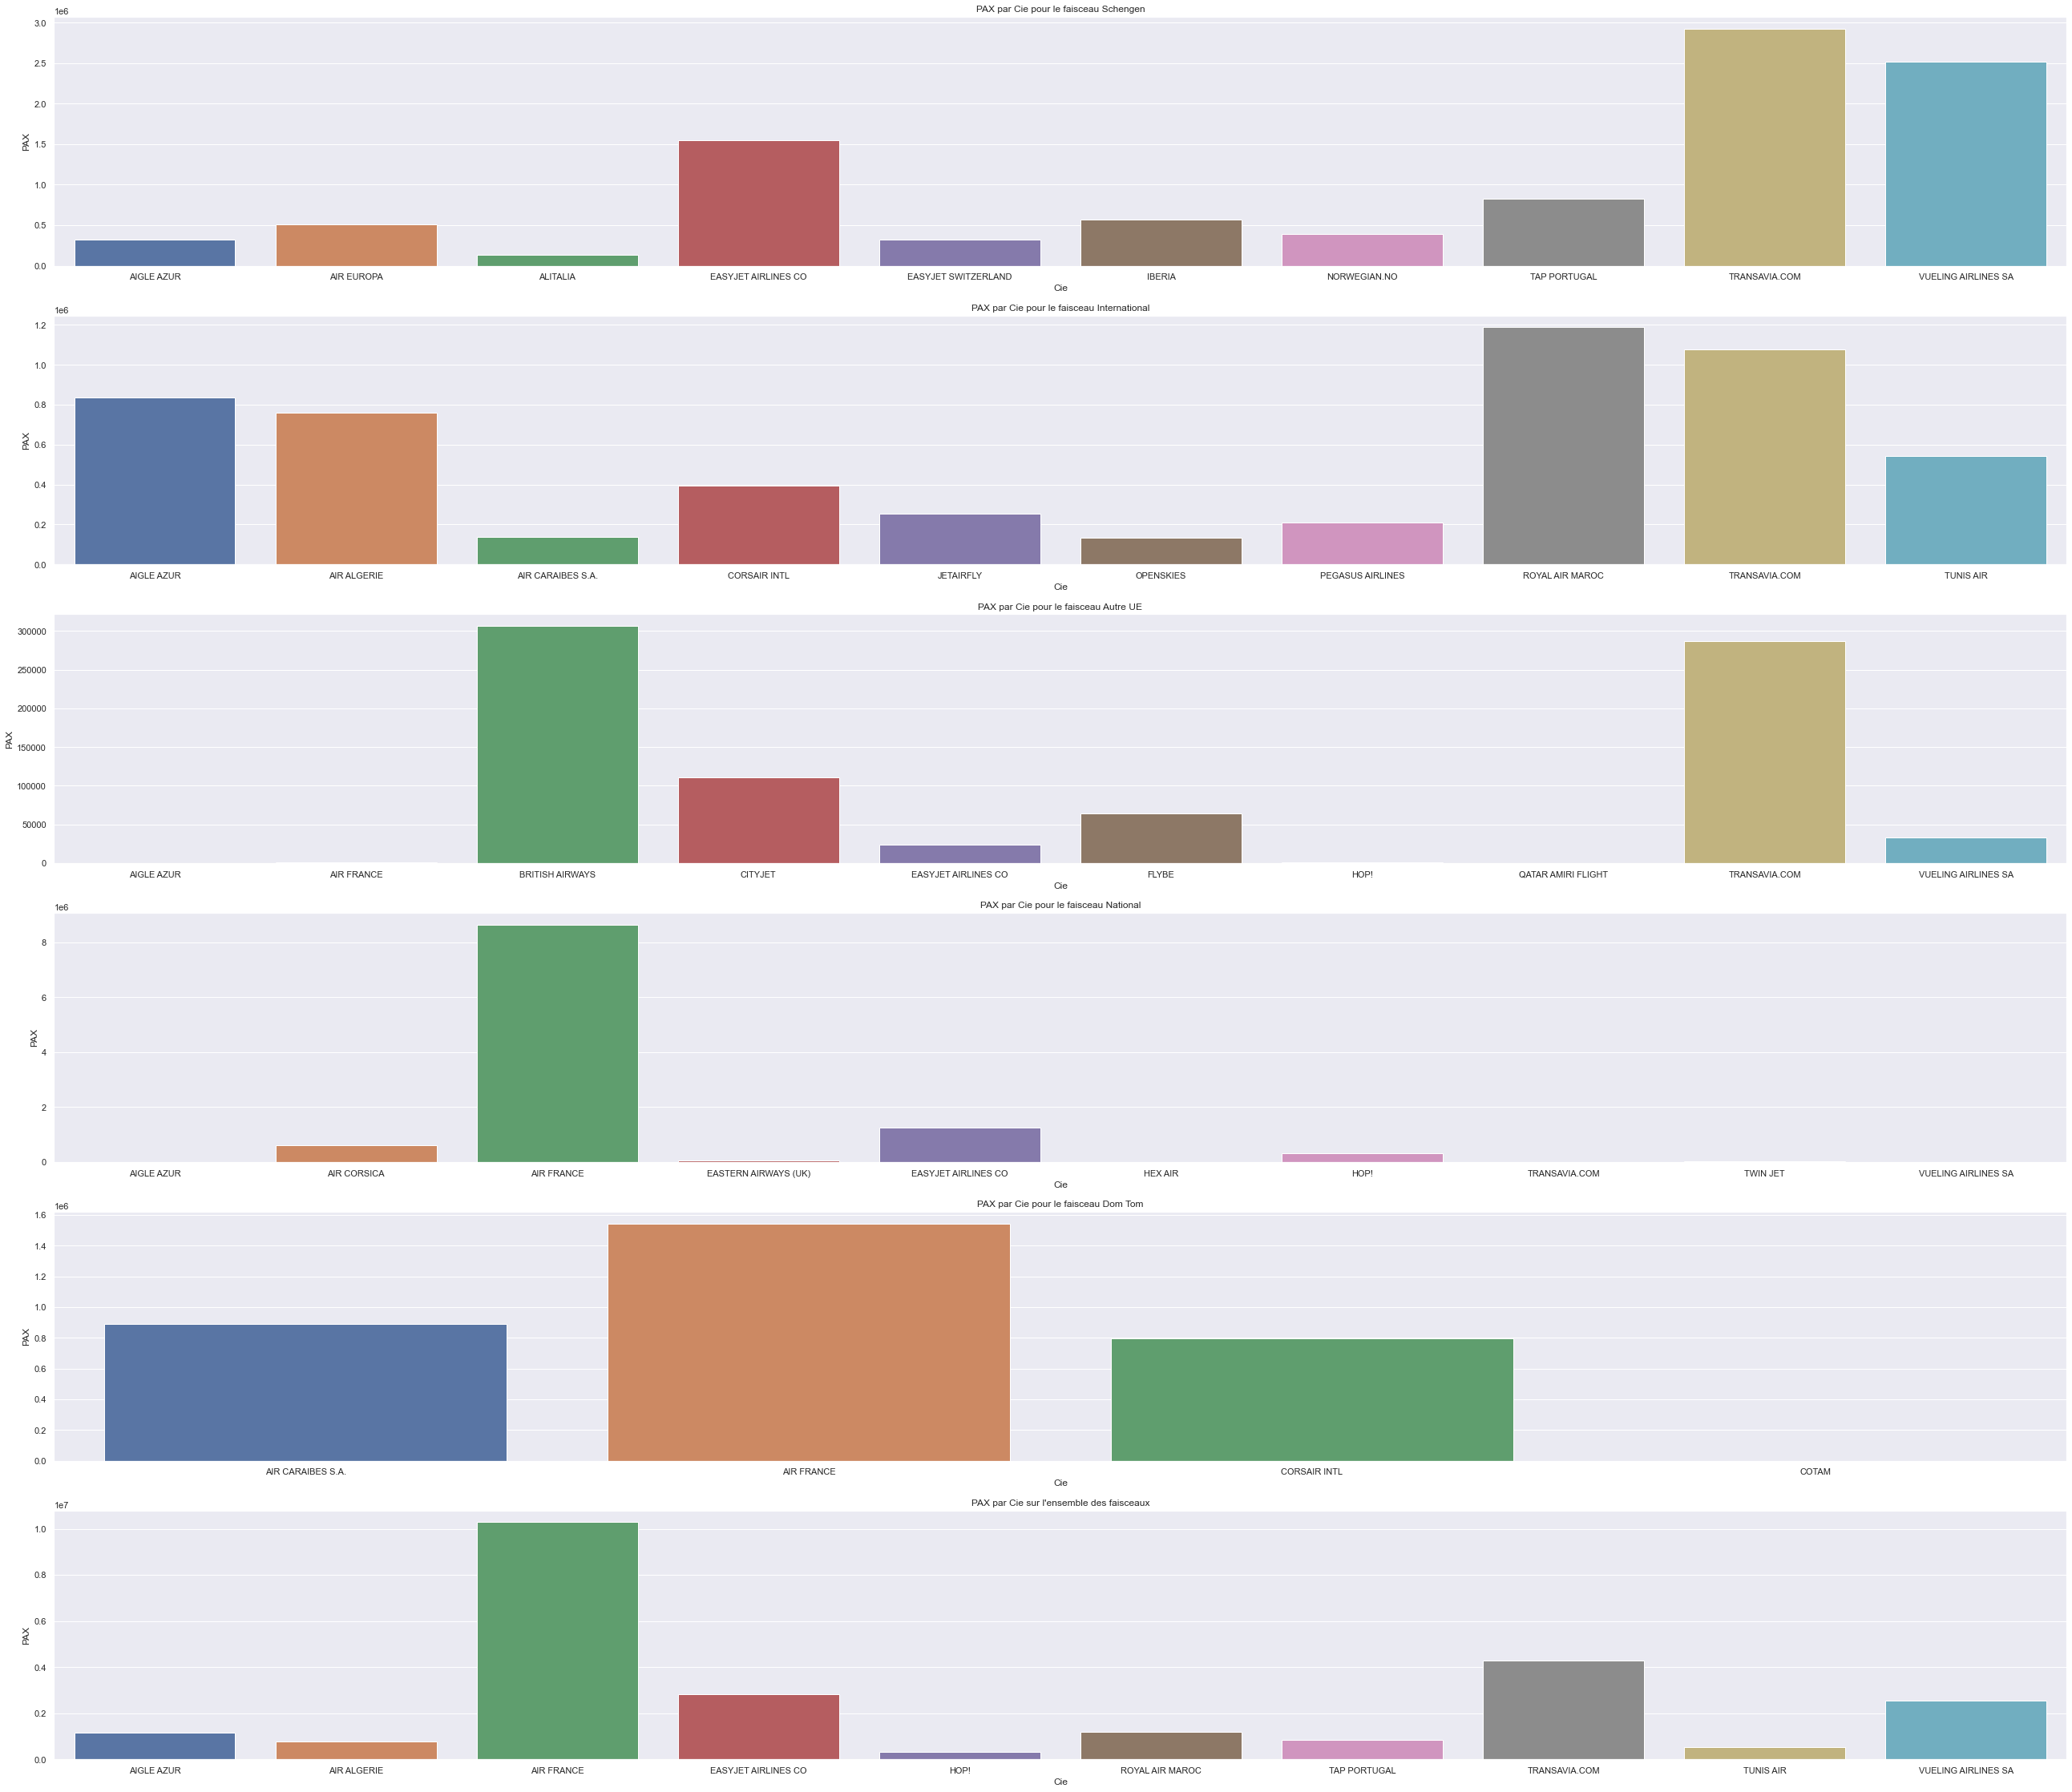

In [50]:
bar_chart_fsc('Cie', 'PAX', 'sum', 10)

## Affichage des variables sur carte

In [338]:
# On charge le fond de carte 
fond_carte = gpd.read_file('https://raw.githubusercontent.com/AtelierCartographie/Khartis/master/public/data/map/W-110m-2015-modified.json')
fond_carte = fond_carte.astype({'name':'str'})

In [339]:
df.Pays = df.Pays.str.capitalize()

In [370]:
len(pd.unique(df.Pays))

86

In [342]:
pd.unique(fond_carte.name)[:5], pd.unique(df.Pays)[:5]

(array(['Afghanistan', 'Angola', 'Albania', 'United Arab Emirates',
        'Argentina'], dtype=object),
 array(['Portugal', 'France', 'Espagne', 'Algerie', 'Tunisie'],
       dtype=object))

In [359]:
df = df.astype({'MVT_FQM':'float64', 'PAX_FQM':'float64', 'Coeff_Rempl_FQM':'float64', 'Sièges Corrections_ICI':'float64', 'MVT':'int64'})
df_pays = df.groupby('Pays').agg({'MVT_FQM':'sum','PAX_FQM':'sum','Coeff_Rempl_FQM':'mean', 'Sièges Corrections_ICI':'sum', 'MVT':'sum', 'Taux de remplissage réel':'mean', 'PAX':'sum'})
df_map = pd.merge(fond_carte, df_pays,left_on='name', right_on='Pays')

In [369]:
df_map

id iso_a2        name  square  \
0   None     BS     Bahamas       0   
1   None     CA      Canada       0   
2   None     CG       Congo       0   
3   None     CU        Cuba       0   
4   None     GA       Gabon       0   
5   None     HT       Haiti       0   
6   None     IR        Iran       0   
7   None     IL      Israel       0   
8   None     KZ  Kazakhstan       0   
9   None     LU  Luxembourg       0   
10  None     MG  Madagascar       0   
11  None     ML        Mali       0   
12  None     NE       Niger       0   
13  None     OM        Oman       0   
14  None     QA       Qatar       0   
15  None     SN     Senegal       0   
16  None     TG        Togo       0   
17  None     UA     Ukraine       0   
18  None     UY     Uruguay       0   
19  None     VN     Vietnam       0   
20  None     PT    Portugal       0   
21  None     FR      France       0   
22  None     KE       Kenya       0   

                                             geometry   MVT_FQM       PAX_FQM  \
0   MULTIPOLYGON (((-77.53375 23.75797, -77.78578 ...      10.0  2.751991e+03   
1   MULTIPOLYGON (((-63.67237 46.55842, -62.95230 ...     180.0  4.900694e+04   
2   POLYGON ((18.45185 3.49654, 18.37984 2.88718, ...       0.0  0.000000e+00   
3   POLYGON ((-79.69397 22.75929, -79.29793 22.386...     138.0  2.927889e+04   
4   POLYGON ((13.08731 2.26089, 13.01530 1.83771, ...       0.0  0.000000e+00   
5   POLYGON ((-71.70117 19.71246, -71.62916 19.170...      69.0  1.864837e+04   
6   POLYGON ((46.13861 38.73822, 46.49865 38.77208...     209.0  3.989975e+04   
7   POLYGON ((35.80558 33.28778, 35.84158 32.86461...     766.0  1.073215e+05   
8   POLYGON ((87.36274 49.21594, 86.60666 48.55579...       0.0  0.000000e+00   
9   POLYGON ((6.17462 49.46984, 5.88659 49.45291, ...       0.0  0.000000e+00   
10  POLYGON ((50.06301 -13.54878, 50.20702 -14.750...      86.0  1.897267e+04   
11  POLYGON ((4.26643 19.15387, 4.26643 16.85182, ...     215.0  2.751866e+04   
12  POLYGON ((14.85149 22.86085, 15.10351 21.30358...       0.0  0.000000e+00   
13  MULTIPOLYGON (((53.12331 16.64870, 52.79928 17...       0.0  0.000000e+00   
14  POLYGON ((51.39514 24.63817, 51.10711 24.55353...       0.0  0.000000e+00   
15  POLYGON ((-12.18722 14.61748, -12.11521 13.991...     635.0  1.586780e+05   
16  POLYGON ((0.88209 10.99513, 0.77408 10.47040, ...       0.0  0.000000e+00   
17  POLYGON ((38.21782 47.10008, 37.42574 47.01545...       0.0  0.000000e+00   
18  POLYGON ((-53.37534 -33.77636, -53.80738 -34.3...       0.0  0.000000e+00   
19  POLYGON ((108.06481 21.55748, 106.73267 20.694...       0.0  0.000000e+00   
20  MULTIPOLYGON (((-28.71287 38.83979, -28.06481 ...   16481.0  2.215720e+06   
21  MULTIPOLYGON (((9.55896 42.15745, 9.23492 41.3...  103271.0  1.085854e+07   
22  POLYGON ((35.98560 4.61372, 36.16562 4.46137, ...       0.0  0.000000e+00   

    Coeff_Rempl_FQM  Sièges Corrections_ICI     MVT  Taux de remplissage réel  \
0          0.728040            3.914917e+03      11                  0.814308   
1          0.756280            6.750513e+04     204                  0.817389   
2               NaN            2.768310e+02       1                  0.000000   
3          0.778951            2.116460e+04     153                  0.760527   
4               NaN            2.970185e+02       2                  0.000000   
5          0.727871            2.566535e+04      71                  0.807156   
6          0.731448            5.431800e+04     210                  0.649983   
7          0.741304            1.474446e+05     784                  0.913226   
8               NaN            0.000000e+00       2                       NaN   
9               NaN            1.686762e+04      33                  0.002792   
10         0.725699            2.523090e+04      88                  0.931301   
11         0.735596            3.530677e+04     218                  0.660686   
12              NaN            0.000000e+00       4                    

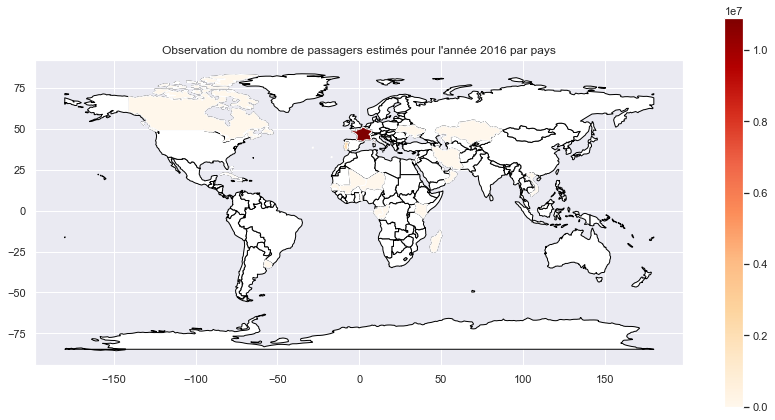

In [372]:
fig, ax = plt.subplots(figsize=(12,6))
world.plot(ax=ax, color='white', edgecolors='black')
df_map.plot(column='PAX',ax=ax,  cmap='OrRd', legend=True)
plt.title("Observation du nombre de passagers estimés pour l'année 2016 par pays")
plt.tight_layout()
plt.show()

Pays où les prédictions sont les meilleures ? 

In [362]:
df_map['Diff_PAX']=abs(df_map['PAX']-df_map['PAX_FQM'])
df_map['Diff_Rempl']=abs(df_map['Coeff_Rempl_FQM']-df_map['Taux de remplissage réel'])

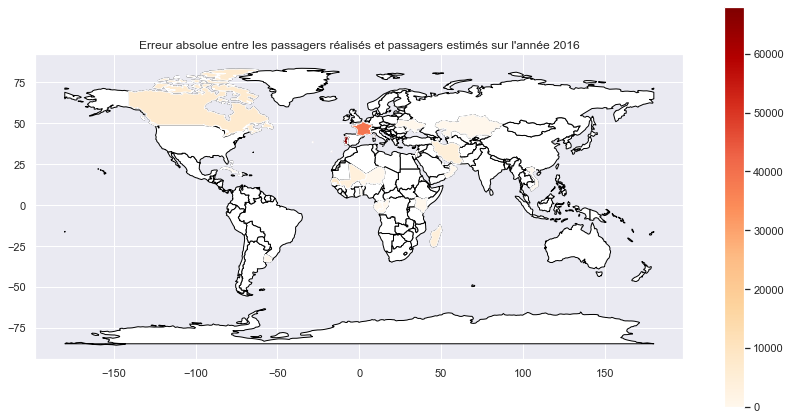

In [366]:
fig, ax = plt.subplots(figsize=(12,6))
world.plot(ax=ax, color='white', edgecolors='black')
df_map.plot(column='Diff_PAX',ax=ax,  cmap='OrRd', legend=True)
plt.tight_layout()
plt.title("Erreur absolue entre les passagers réalisés et passagers estimés sur l'année 2016")
plt.show()

Erreur absolue plus grande en France métropolitaine. 

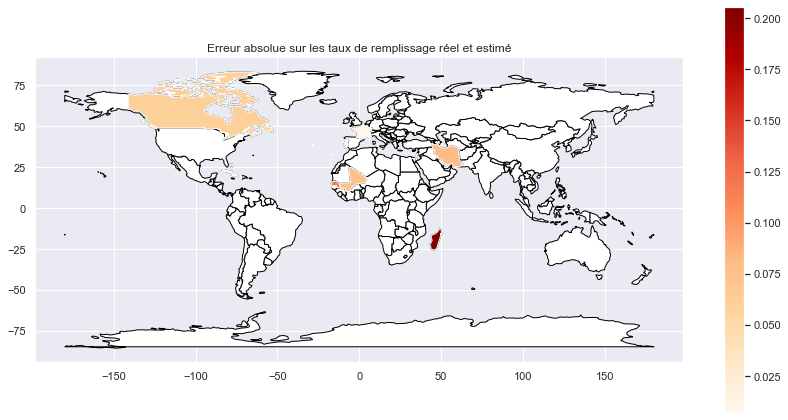

In [365]:
fig, ax = plt.subplots(figsize=(12,6))
world.plot(ax=ax, color='white', edgecolors='black')
df_map.plot(column='Diff_Rempl',ax=ax,  cmap='OrRd', legend=True)
plt.tight_layout()
plt.title('Erreur absolue sur les taux de remplissage réel et estimé')
plt.show()

Erreur relative plus forte au Canada, en Iran, et Madagascar. 

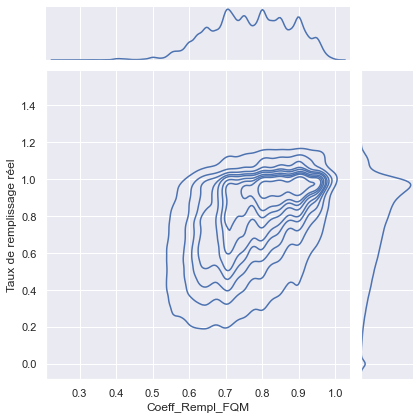

In [199]:
sns.jointplot(x=df["Coeff_Rempl_FQM"], y=df["Taux de remplissage réel"], kind='kde')
#sns.jointplot(x=df["sepal_length"], y=df["sepal_width"], kind='hex')
#sns.jointplot(x=df["sepal_length"], y=df["sepal_width"], kind='kde')

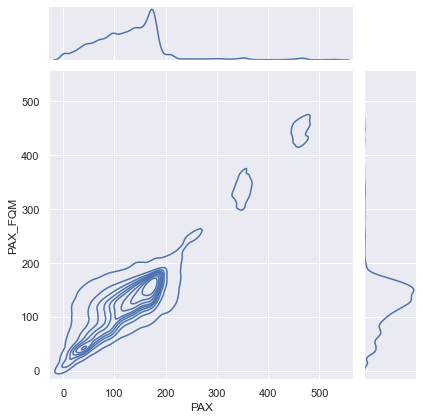

In [201]:
sns.jointplot(x=df["PAX"], y=df["PAX_FQM"], kind='kde')
